In [1]:
#!pip install --upgrade covsirphy

In [2]:
import covsirphy as cs
cs.__version__

'2.15.0'

In [3]:
from IPython.display import IFrame, display
#filepath = "http://wikipedia.org" # works with websites too!
filepath = "../Images/CrispFramework.PNG"
IFrame(filepath, width=800, height=300)

### Business Understanding

1. The scope of this project is to develop a SIR Model for CANADA.
2. Simulate the Effectiveness of Lockdown.

### General Packages

In [4]:
from collections import defaultdict
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import functools
from IPython.display import display, Markdown
import math
import os
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import numpy as np
import pandas as pd
# import dask.dataframe as dd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
import scipy as sci
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import sympy as sym
from scipy.integrate import odeint

### Plotting Configuration

In [5]:
# Ramdam
np.random.seed(123)
os.environ["PYTHONHASHSEED"] = "123"
# Matplotlib
plt.style.use("seaborn-ticks")
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 11.0
plt.rcParams["figure.figsize"] = (15, 10)
# Pandas
pd.set_option("display.max_colwidth", 1000)

### Load Dataset

In [6]:
data_loader = cs.DataLoader("input")
jhu_data = data_loader.jhu()

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/

Please set verbose=2 to see the detailed citation list.


Retrieving COVID-19 dataset in Japan from https://github.com/lisphilar/covid19-sir/data/japan


### Cleaned dataset is saved in jhu_data, lets load the dataset.

In [7]:
jhu_data.cleaned().head()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
0,2020-01-01,Afghanistan,-,0,0,0,0
1,2020-01-02,Afghanistan,-,0,0,0,0
2,2020-01-03,Afghanistan,-,0,0,0,0
3,2020-01-04,Afghanistan,-,0,0,0,0
4,2020-01-05,Afghanistan,-,0,0,0,0


### Creating Canada wide subset of data

In [8]:
jhu_data.subset("Canada", province=None)

,Date,Confirmed,Infected,Fatal,Recovered
0,2020-03-26,4018,3749,39,230
1,2020-03-27,4675,4366,53,256
2,2020-03-28,5386,4825,59,502
3,2020-03-29,6255,5672,61,522
4,2020-03-30,7424,6267,89,1068
...,...,...,...,...,...
368,2021-03-29,971719,45212,22900,903607
369,2021-03-30,976597,46394,22926,907277
370,2021-03-31,982110,47858,22959,911293
371,2021-04-01,987918,49568,23002,915348


### How many days have passed

In [9]:
df = jhu_data.cleaned()
jhu_first_date, jhu_last_date = df["Date"].min(), df["Date"].max()
jhu_elapsed = (jhu_last_date - jhu_first_date).days
print(f"{jhu_elapsed} days have passed from the date of the first record.")

457 days have passed from the date of the first record.


### Total Population
#### We need population values to calculate the number of "susceptible" cases.

Susceptible = Total population - Confirmed 

In [10]:
#Make use of dataloader to get population of Countries.
population_data = data_loader.population()
# Show cleaned dataset
population_data.cleaned().tail()
# show cleaned Canada data
population_data.value("Canada", province = None)

37057765

### Population pyramid

#### To estimate the average number of days people go out we going to use population pyramid

In [11]:
pyramid_data = data_loader.pyramid()

### Template Data (The average number of days people go out)

We are using the average number of days a person of each age group usually go out. The template is  provided by @marcoferrante.

In [12]:
# Estmation by marcoferrante

_period_of_life_list = [
    "nursery", "nursery school", "elementary school", "middle school", "high school", "university/work" , "work", "work", "work",
    "work", "retired", "retired", "retired"
]

df = pd.DataFrame({
    
    "Age_first": [0, 3, 6, 11, 14, 19, 26, 36, 46, 56, 66, 76, 86],
        "Age_last": [2, 5, 10, 13, 18, 25, 35, 45, 55, 65, 75, 85, 95],
        "Period_of_life": _period_of_life_list,
        "Days": [3, 5, 6, 6, 7, 7, 6, 5, 5, 5, 4, 3, 2]
    
    
    
})

# Adjustment by @marcoferrante
df["Types"] = df["Period_of_life"].replace(
    {
        "nursery": "school",
        "nursery school": "school",
        "elementary school": "school",
        "middle school": "school",
        "high school": "school",
        "university/work": "school/work"
    }
)


df["School"] = df[["Types","Days"]].apply(lambda x : x[1] if "school" in x[0] else 0, axis = 1)
df["Office"] = df[["Types", "Days"]].apply(lambda x : x[1] if "work" in x[0] else 0, axis =1)
df["Others"] = df["Days"] - df[["School", "Office"]].sum(axis=1)

df.loc[df["Others"]<0, "Others"]=0
df.loc[df.index[1:5],"School"] -=1
df.loc[df.index[1:5],"Others"] +=1
df.loc[df.index[5], ["School", "Office", "Others"]] = [3, 3, 1]
df[["School", "Office", "Others"]] = df[["Days", "School", "Office", "Others"]].apply(lambda x : x[1:]/sum(x[1:])*x[0], 
                                                                                      axis=1).astype(np.int64)
df.loc[df.index[6:10], "Others"] += 1
# df = df.drop(["Days", "Types"], axis=1)



#show dataset
_out_df = df.copy()

_out_df.head(10)



,Age_first,Age_last,Period_of_life,Days,Types,School,Office,Others
0,0,2,nursery,3,school,3,0,0
1,3,5,nursery school,5,school,4,0,1
2,6,10,elementary school,6,school,5,0,1
3,11,13,middle school,6,school,5,0,1
4,14,18,high school,7,school,6,0,1
5,19,25,university/work,7,school/work,3,3,1
6,26,35,work,6,work,0,6,1
7,36,45,work,5,work,0,5,1
8,46,55,work,5,work,0,5,1
9,56,65,work,5,work,0,5,1


- Now this Pyramid data will be combined with Canada Specific Data.

In [13]:
def go_out(country, pyramid_data=pyramid_data):
    """
    Return the estimated number of days people usually go out.
    Args:
        country (str): coutry name
        pyramid_data (covsirphy.PopulationPyramidData): pyramid dataset
    
    Returns:
        pandas.DataFrame
    """
    p_df = pyramid_data.subset(country)
    p_df["Cumsum"] = p_df["Population"].cumsum()
    df = pd.merge(_out_df, p_df, left_on="Age_last", right_on="Age", how="left")
    df["Population"] = df["Cumsum"].diff()
    df.loc[df.index[0], "Population"] = df.loc[df.index[0], "Cumsum"]
    df["Population"] = df["Population"].astype(np.int64)
    df["Portion"] = df["Population"] / df["Population"].sum()
    return df.drop(["Per_total", "Cumsum"], axis=1)

go_out("Canada")

,Age_first,Age_last,Period_of_life,Days,Types,School,Office,Others,Age,Population,Portion
0,0,2,nursery,3,school,3,0,0,2,1193571,0.034264
1,3,5,nursery school,5,school,4,0,1,5,1193646,0.034266
2,6,10,elementary school,6,school,5,0,1,10,1987203,0.057047
3,11,13,middle school,6,school,5,0,1,13,1186425,0.034059
4,14,18,high school,7,school,6,0,1,18,2007971,0.057643
5,19,25,university/work,7,school/work,3,3,1,25,3365119,0.096603
6,26,35,work,6,work,0,6,1,35,5302920,0.152232
7,36,45,work,5,work,0,5,1,45,5012608,0.143898
8,46,55,work,5,work,0,5,1,55,4961567,0.142432
9,56,65,work,5,work,0,5,1,65,5165771,0.148294


### Data Cleaning: Linelist (COVID19_line_list_data.csv) <a href = "https://github.com/beoutbreakprepared/nCoV2019/blob/master/latest_data/latestdata.tar.gz">Link</a>

This dataset contains clinical trails of many reported case.


In [14]:
# linelist_raw = pd.read_csv("..\\data\\raw\\Covid-19_line_data.xlsx",header=0, encoding = 'unicode_escape')
# linelist_raw.head()

# import csv

# data = open(r"C://Users//yrsin//Desktop//w2021//SIRModel//sirmodel//data//raw//NewData.xlsx", encoding = 'unicode_escape')
# data = pd.read_csv(data)
# # print(data)


linelist_raw = pd.read_csv("../data/raw/test.csv")
linelist_raw.head()

,reporting date,location,country,gender,age,symptom_onset,If_onset_approximated,hosp_visit_date,international_traveler,domestic_traveler,exposure_start,exposure_end,traveler,visiting Wuhan,from Wuhan,death,recovered,symptom
0,1/20/2020,"Shenzhen, Guangdong",China,male,66.0,1/3/2020,0.0,1/11/2020,NaN,NaN,12/29/2019,1/4/2020,NaN,1.0,0.0,0,0,NaN
1,1/20/2020,Shanghai,China,female,56.0,1/15/2020,0.0,1/15/2020,NaN,NaN,NaN,1/12/2020,NaN,0.0,1.0,0,0,NaN
2,1/21/2020,Zhejiang,China,male,46.0,1/4/2020,0.0,1/17/2020,NaN,NaN,NaN,1/3/2020,NaN,0.0,1.0,0,0,NaN
3,1/21/2020,Tianjin,China,female,60.0,NaN,NaN,1/19/2020,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0,0,NaN
4,1/21/2020,Tianjin,China,male,58.0,NaN,NaN,1/14/2020,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,NaN


In [15]:
linelist_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3397 entries, 0 to 3396
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   reporting date          3396 non-null   object 
 1   location                3167 non-null   object 
 2   country                 3234 non-null   object 
 3   gender                  1685 non-null   object 
 4   age                     1507 non-null   float64
 5   symptom_onset           684 non-null    object 
 6   If_onset_approximated   655 non-null    float64
 7   hosp_visit_date         620 non-null    object 
 8   international_traveler  826 non-null    float64
 9   domestic_traveler       802 non-null    float64
 10  exposure_start          194 non-null    object 
 11  exposure_end            488 non-null    object 
 12  traveler                660 non-null    float64
 13  visiting Wuhan          1606 non-null   float64
 14  from Wuhan              1602 non-null   

In [16]:
df = linelist_raw.loc[:, ~linelist_raw.columns.str.startswith("Unnamed:")]
# df = df.drop(["id", "case_in_country", "summary", "source", "link"], axis=1)
# Date
case_date_dict = {
    "reporting date": "Confirmed_date",
    "exposure_start": "Exposed_date",
    "exposure_end": "Quarantined_date",
    "hosp_visit_date": "Hospitalized_date",
    "symptom_onset": "Onset_date",
    "death": "Deaths_date",
    "recovered": "Recovered_date"    
}
df["death"] = df["death"].replace({"0": "", "1": ""})
df["recovered"] = df["recovered"].replace({"0": "", "1": "", "12/30/1899": "12/30/2019"})
# for (col, _) in case_date_dict.items():
#     df[col] = pd.to_datetime(df[col])
# df = df.rename(case_date_dict, axis=1)
df = df.rename(columns={"reporting date": "Confirmed_date",
    "exposure_start": "Exposed_date",
    "exposure_end": "Quarantined_date",
    "hosp_visit_date": "Hospitalized_date",
    "symptom_onset": "Onset_date",
    "death": "Deaths_date",
    "recovered": "Recovered_date" })
# df.head()
# Location
df["Country"] = df["country"].fillna("-")
df["Province"] = df["location"].fillna("-")
df["Province"] = df[["Country", "Province"]].apply(lambda x: "-" if x[0] == x[1] else x[1], axis=1)
# Personal
df["Gender"] = df["gender"].fillna("-").str.capitalize()
df["Age"] = df["age"].fillna(df["age"].median()).astype(np.int64) ## Fill in NA with median
df["From_Wuhan"] = df["from Wuhan"]
df["To_Wuhan"] = df["visiting Wuhan"]
# Medical
df["Events"] = df["symptom"].fillna("-")
# Order of columns
linelist_df = df.loc[
    :,
    [
        "Country", "Province",
        "Exposed_date", "Onset_date", "Hospitalized_date", "Confirmed_date", "Quarantined_date", "Deaths_date", "Recovered_date",
        "Events",
        "Gender", "Age", "From_Wuhan", "To_Wuhan"
    ]
]
linelist_df.head()

# df.head()

,Country,Province,Exposed_date,Onset_date,Hospitalized_date,Confirmed_date,Quarantined_date,Deaths_date,Recovered_date,Events,Gender,Age,From_Wuhan,To_Wuhan
0,China,"Shenzhen, Guangdong",12/29/2019,1/3/2020,1/11/2020,1/20/2020,1/4/2020,,,-,Male,66,0.0,1.0
1,China,Shanghai,NaN,1/15/2020,1/15/2020,1/20/2020,1/12/2020,,,-,Female,56,1.0,0.0
2,China,Zhejiang,NaN,1/4/2020,1/17/2020,1/21/2020,1/3/2020,,,-,Male,46,1.0,0.0
3,China,Tianjin,NaN,NaN,1/19/2020,1/21/2020,NaN,,,-,Female,60,0.0,1.0
4,China,Tianjin,NaN,NaN,1/14/2020,1/21/2020,NaN,,,-,Male,58,0.0,0.0


In [17]:
# linelist_df.info()
# linelist_df.describe(include="all").fillna("-")
period_df = linelist_df.loc[:, ["Exposed_date", "Onset_date", "Confirmed_date"]]
period_df['Onset_date'] = pd.to_datetime(period_df['Onset_date'],errors='coerce')
period_df['Exposed_date'] = pd.to_datetime(period_df['Exposed_date'],errors='coerce')
period_df['Confirmed_date'] = pd.to_datetime(period_df['Confirmed_date'],errors='coerce')
period_df["Latent [min]"] = (period_df["Onset_date"] - period_df["Exposed_date"]).dt.total_seconds() / 60
period_df["Waiting [min]"] = (period_df["Confirmed_date"] - period_df["Onset_date"]).dt.total_seconds() / 60
period_df["Latent [day]"] = period_df["Latent [min]"] / 60 / 24
period_df["Waiting [day]"] = period_df["Waiting [min]"] / 60 / 24
period_df["Latent + Waiting [day]"] = period_df["Latent [day]"] + period_df["Waiting [day]"]
period_df.dropna(axis=0).tail()



period_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3397 entries, 0 to 3396
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Exposed_date            194 non-null    datetime64[ns]
 1   Onset_date              683 non-null    datetime64[ns]
 2   Confirmed_date          3396 non-null   datetime64[ns]
 3   Latent [min]            92 non-null     float64       
 4   Waiting [min]           683 non-null    float64       
 5   Latent [day]            92 non-null     float64       
 6   Waiting [day]           683 non-null    float64       
 7   Latent + Waiting [day]  92 non-null     float64       
dtypes: datetime64[ns](3), float64(5)
memory usage: 212.4 KB


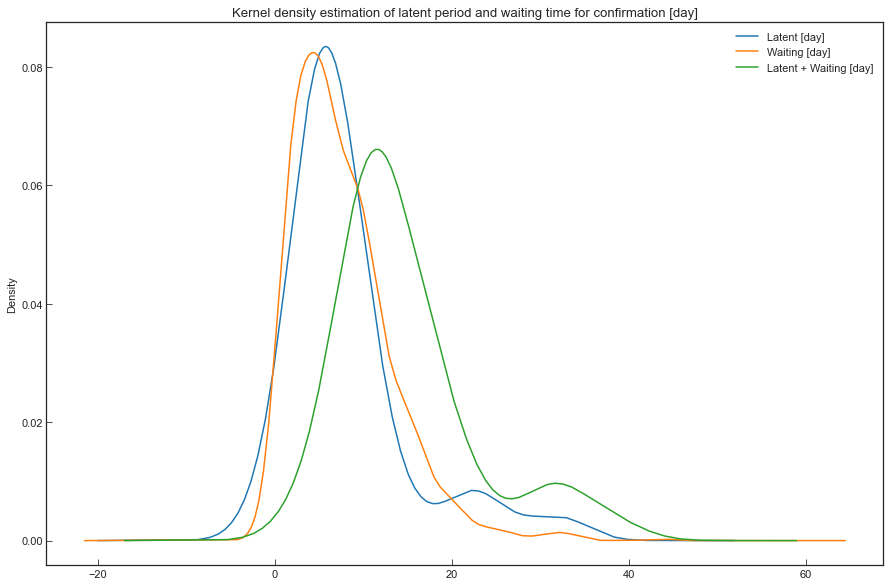

,count,mean,std,min,25%,50%,75%,max
Latent [day],92.0,8.163043,6.934984,-2.0,4.0,6.0,9.00,34.0
Waiting [day],683.0,7.590044,5.582389,0.0,3.0,6.0,10.00,43.0
Latent + Waiting [day],92.0,14.793478,7.838392,2.0,10.0,13.0,17.25,40.0


In [18]:
cols = ["Latent [day]", "Waiting [day]", "Latent + Waiting [day]"]
period_df[cols].plot.kde()
plt.title("Kernel density estimation of latent period and waiting time for confirmation [day]")
plt.show()
period_df[cols].describe().T

### Lets take a look at what are the measures implemented by Canada

Government of Canada took multiple intervention measures to stop the spread of COVID-19. Lets have a look at the same.

In [19]:
canada_action_raw = pd.read_excel("input/covid-19-intervention-scan-data-tables-en.xlsx", sheet_name = "Intervention scan", header=2)

# canada_action_raw.head()

 ### Data Cleaning

In [20]:
def canada_action(canada_action_raw):

    #Removing the columns
    canada_action_raw = canada_action_raw.loc[:,:'Indigenous \npopulation group']
#     print(canada_action_raw.columns)
#     canada_action_raw.head()

    canada_action_raw[canada_action_raw['Jurisdiction ']=='Can.']

    # Slicing Intervention Summary to get Who implemented the policy what was the policy and how long it will be effective.

    Intervention_summary = canada_action_raw['Intervention summary'].str.split("Who: |\nWhat: |\nEffective until:",
                                                                                    expand=True)


    # Sliced Columns are expanded into individual columns.

    Intervention_summary.rename(columns={1: "Who Implemented", 2: "What Implemented", 3: "Effective Until"},
                                inplace = True)
    # Intervention_summary.head()

    # concatinating intervention_scan data and intervention summary data.

    canada_action_raw = pd.concat([canada_action_raw,Intervention_summary],axis=1)
    canada_action_raw.head()

    # Dropping Secondary source

    canada_action_raw.drop(['Secondary source',0],axis=1,inplace=True)

    # Renaming the columns

    canada_action_raw.rename(columns = {"Indigenous \npopulation group": "Indigenous population group",'Primary source\n(news release or specific resource)': 'Primary source'},inplace=True)
    # canada_action_raw.head()


    #converting the date column to datetime format and extracting month from it.

    canada_action_raw[canada_action_raw['Date announced']=='No data']

    DateColumns = ['Date announced','Date implemented', 'Effective Until']

    for column in DateColumns:

        canada_action_raw[column] = pd.to_datetime(canada_action_raw[column], infer_datetime_format=True,errors='coerce')
    #intervention_scan_data['Date implemented'] = pd.to_datetime(intervention_scan_data['Date implemented'], infer_datetime_format=True,errors='coerce')
    #intervention_scan_data['Effective Until'] = pd.to_datetime(intervention_scan_data['Effective Until'], infer_datetime_format=True,errors='coerce')

    # Rearranging the columns

    canada_action_raw = canada_action_raw[['Entry ID', 'Jurisdiction ','Level','Date announced','Date implemented',
                                                     'Intervention category','Intervention type','Who Implemented',
                                                     'What Implemented','Effective Until','Indigenous population group',
                                                     'Primary source']]

    return(canada_action_raw)

canada_action(canada_action_raw)

,Entry ID,Jurisdiction,Level,Date announced,Date implemented,Intervention category,Intervention type,Who Implemented,What Implemented,Effective Until,Indigenous population group,Primary source
0,BC007,B.C.,Provincial/territorial,2020-03-15,2020-03-16,Case management,Case management — test criteria,"BC Centre for Disease Control, Provincial Health Services Authority",Testing criteria first published. Testing is prioritized for patients with respiratory symptoms who are hospitalized or likely to be hospitalized; health care workers; residents of long term care facilities; part of an investigation of a cluster or outbreak.,NaT,No,http://www.bccdc.ca/health-info/diseases-conditions/covid-19/testing/phases-of-covid-19-testing-in-bc
1,ON021,Ont.,Provincial/territorial,2020-03-17,2020-03-17,Closures,Closures — recreation,Office of the Premier,"Closed all facilities providing indoor recreational programs and public libraries, with subsequent extensions (see secondary source column)",2020-06-12,No,https://news.ontario.ca/opo/en/2020/03/ontario-enacts-declaration-of-emergency-to-protect-the-public.html
2,ON022,Ont.,Provincial/territorial,2020-03-17,2020-03-17,Closures,Closures — recreation,Office of the Premier,"Closed all theatres including those offering live performances of music, dance and other art forms, as well as cinemas that show movies and concert venues, with subsequent extensions (see secondary source column)",2020-06-12,No,https://news.ontario.ca/opo/en/2020/03/ontario-enacts-declaration-of-emergency-to-protect-the-public.html
3,ON023,Ont.,Provincial/territorial,2020-03-17,2020-03-17,Closures,Closures — non-essential services,Office of the Premier,"Closures of all bars and restaurants, except to the extent that such facilities provide takeout food and delivery, with subsequent extensions (see secondary source column)",2020-06-12,No,https://news.ontario.ca/opo/en/2020/03/ontario-enacts-declaration-of-emergency-to-protect-the-public.html
4,ON111,Ont.,Provincial/territorial,2020-03-17,2020-03-17,Closures,Closures — daycares,Office of the Premier,"Closures of all licensed child care facilities and EarlyON programs, with subsequent extensions (see secondary source column)",2020-06-12,No,https://news.ontario.ca/opo/en/2020/03/ontario-enacts-declaration-of-emergency-to-protect-the-public.html
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,SK057,Sask.,Provincial/territorial,NaT,NaT,Health workforce,Health workforce — licence reinstatement/reclassification,Saskatchewan Society of Medical Laboratory Technologists,"Waived or modified registration requirements for former registered medical laboratory technologists, allowing them to apply for temporary registration during the pandemic on an expedited basis and at no cost",NaT,No,https://ssmlt.org/document/3967/Covid%20Callout%20website.pdf
1496,SK058,Sask.,Provincial/territorial,NaT,NaT,Health workforce,Health workforce — licence reinstatement/reclassification,College of Physicians and Surgeons of Saskatchewan,"Published information on modification of registration requirements for non-practising/retired/out-of-province physicians, allowing them to apply for return to practice during the pandemic on an expedited basis and at no cost",NaT,No,https://www.cps.sk.ca/imis/CPSS/News___Events/News/News_Items/COVID-19_-_Emergency_Changes_to_Physician_Registration_Requirements.aspx
1497,YT002,Y.T.,Provincial/territorial,NaT,2020-03-13,Contextual information,Contextual information — holiday,Yukon schools,Spring breaks in Y.T. vary by region.,2020-03-27,No,https://yukon.ca/sites/yukon.ca/files/edu/edu-school-calendar-important-dates-2019-2020.pdf
1498,CAN080,Can.,Federal,NaT,NaT,State of emergency,State of emergency,Government of Canada,Activated the federal/provincial/territorial health response plan for biologic events,NaT,No,https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection/canadas-reponse.html?topic=tilelink


### Visualization of cases all over the world

In [21]:
# columns
data_cols = ["Infected", "Fatal", "Recovered"]
#calculating rate
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]

In [22]:
total_df = jhu_data.total()
total_df = total_df.loc[total_df.index<=jhu_last_date, :]
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2021-03-29,127747356,46211805,2794268,78741283,0.021873,0.616383,0.034271
2021-03-30,128316320,46447609,2805450,79063261,0.021864,0.616159,0.034268
2021-03-31,128977720,46744597,2817212,79415911,0.021843,0.615734,0.034259
2021-04-01,129668609,47096176,2828594,79743839,0.021814,0.614982,0.034256
2021-04-02,129979714,47263661,2833234,79882819,0.021798,0.614579,0.034253


### Total Cases over Time

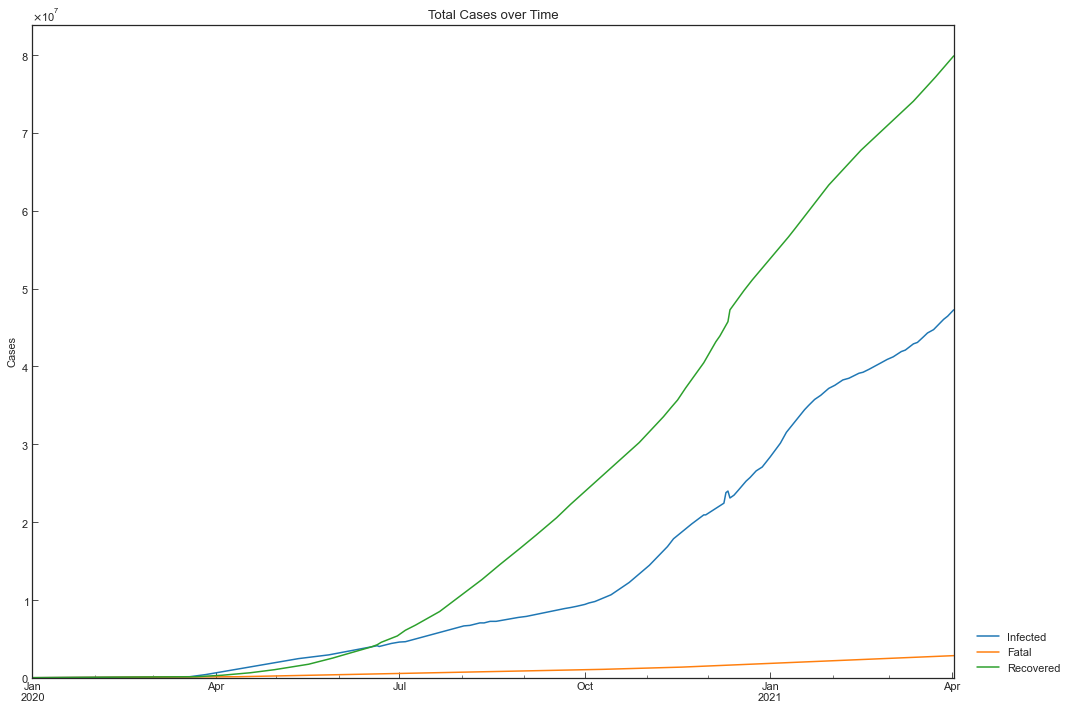

In [23]:
cs.line_plot(total_df[data_cols], "Total Cases over Time")

### Rate over Time

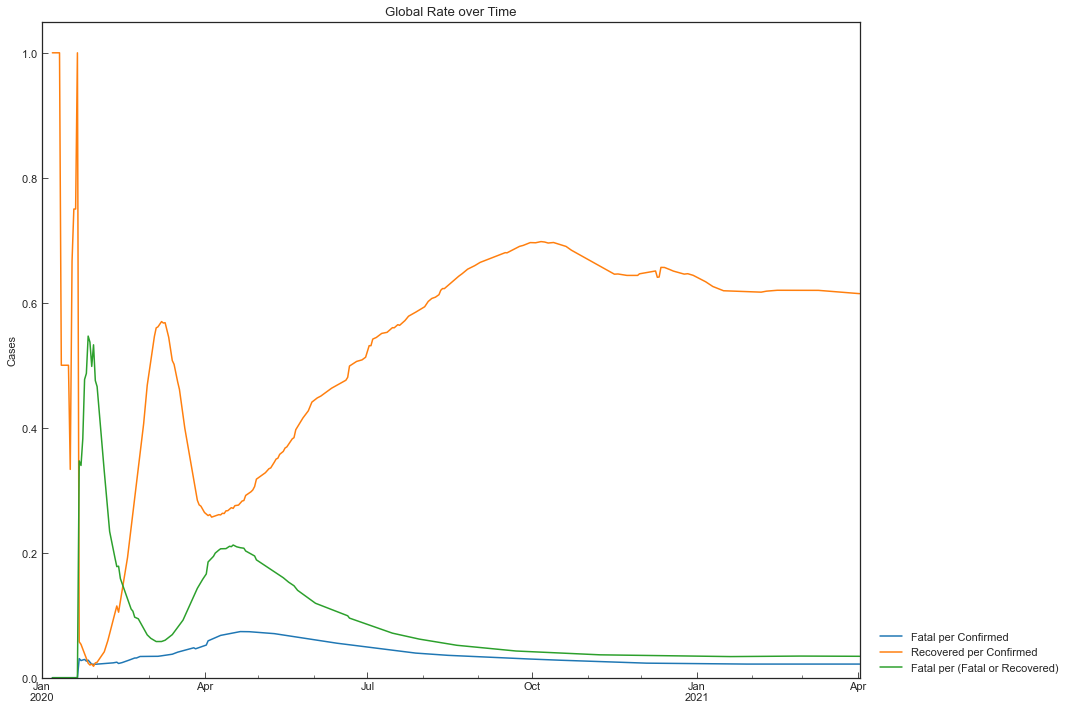

In [24]:
cs.line_plot(total_df[rate_cols], "Global Rate over Time")

### Kernel Density Estimation

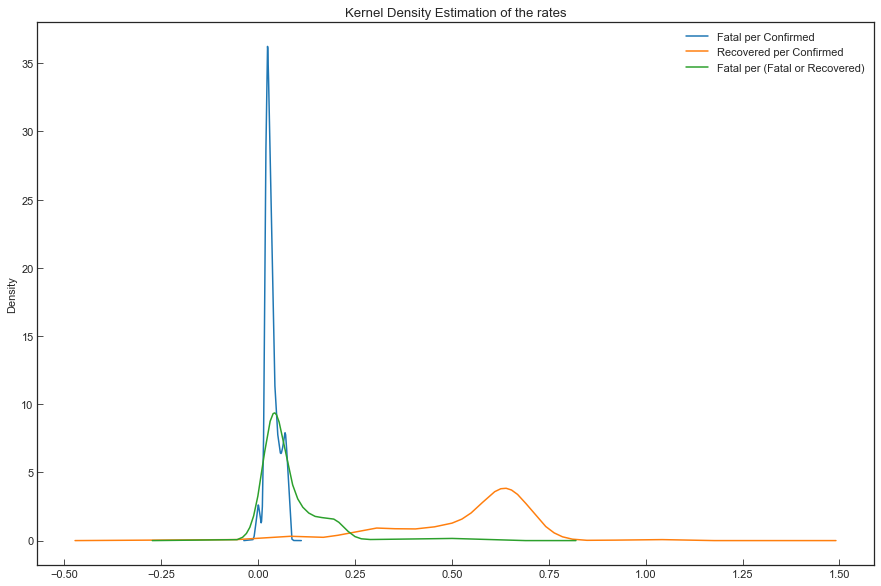

In [25]:
total_df[rate_cols].plot.kde()
plt.title("Kernel Density Estimation of the rates")
plt.show()

In [26]:
total_df[rate_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Fatal per Confirmed,452.0,0.034960,0.017222,0.000000,0.022218,0.029646,0.043878,0.074186
Recovered per Confirmed,452.0,0.530950,0.181616,0.018246,0.443017,0.616973,0.646632,1.000000
Fatal per (Fatal or Recovered),452.0,0.085122,0.087088,0.000000,0.034543,0.047167,0.106401,0.546667


### Grouping by growth factor

We are going to group countries, by the rate of their confirmed cases. 
1. Countries where growth factor is > 1
2. Countries where growth factor < 1

For calculating growth factor we will use
Growth Factor = ΔCn/ΔCn-1

In [27]:

covid_df = jhu_data.cleaned()
df = covid_df.pivot_table(
index="Date", columns="Country", values="Confirmed", aggfunc="sum").fillna(method='ffill').fillna(0)

#growth factor

df = df.diff()/df.diff().shift(freq="D")
df = df.replace(np.inf,np.nan).fillna(1.0)

#Rolling mean (window: 7 days)

df = df.rolling(7).mean().dropna().loc[:covid_df["Date"].max(),:]

growth_value_df = df.round(2)

growth_value_df


Country,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,...,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,"Virgin Islands, U.S.",Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-07,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00
2020-01-08,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00
2020-01-09,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00
2020-01-10,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00
2020-01-11,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-29,1.80,1.01,1.03,1.0,1.11,1.47,0.62,1.19,1.04,1.27,...,1.08,1.02,1.08,1.0,1.10,1.13,2.09,0.99,1.08,1.37
2021-03-30,2.05,1.03,1.04,1.0,1.09,1.48,0.59,1.09,1.06,1.34,...,1.06,1.11,0.88,1.0,1.12,1.13,2.09,1.08,0.86,1.12
2021-03-31,2.12,1.03,1.07,1.0,1.11,1.32,0.74,1.19,1.07,1.15,...,1.00,1.12,1.06,1.0,1.09,1.13,2.09,1.07,0.90,1.13


In [28]:
df = growth_value_df

df = df.iloc[-7:,:].T

day_cols = df.columns.strftime("%d%b%Y")
df.columns = day_cols
last_date = day_cols[-1]

#Grouping
more_col, less_col = "GrowthFactor>1[straight days]","GrowthFactor<1[straight days]"
df[more_col] = ((growth_value_df)>1).iloc[::-1].cumprod().sum(axis=0)
df[less_col] = ((growth_value_df)<1).iloc[::-1].cumprod().sum(axis=0)
df["Group"] = df[[more_col,less_col]].apply(lambda x : "outbreaking" if x[0] >= 7 else "Stopping" if x[1] >=7 else "Crossroad", axis=1)

#Sorting
df = df.loc[:,["Group", more_col, less_col, *day_cols]]
df = df.sort_values(["Group", more_col, less_col], ascending = False)
growth_df = df.copy()
growth_df

Date,Group,GrowthFactor>1[straight days],GrowthFactor<1[straight days],27Mar2021,28Mar2021,29Mar2021,30Mar2021,31Mar2021,01Apr2021,02Apr2021
Country,,,,,,,,,,
Slovakia,outbreaking,236,0,1.21,1.23,1.20,1.59,1.58,1.57,1.46
Spain,outbreaking,229,0,2.32,2.30,1.99,1.95,2.12,1.79,1.69
Bulgaria,outbreaking,173,0,1.38,1.38,1.36,1.37,1.36,1.35,1.20
North Macedonia,outbreaking,150,0,1.12,1.12,1.08,1.35,1.34,1.33,1.17
Czech Republic,outbreaking,124,0,1.20,1.20,1.28,1.27,1.27,1.27,1.13
...,...,...,...,...,...,...,...,...,...,...
Tajikistan,Crossroad,0,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00
Tanzania,Crossroad,0,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00
Thailand,Crossroad,0,0,1.52,1.55,1.50,0.89,0.99,0.88,1.00


In [29]:
# merging both the columns

df = pd.merge(covid_df, growth_df["Group"].reset_index(), on="Country")
covid_df = df.loc[:, ["Date", "Group", *covid_df.columns[1:]]]
covid_df


,Date,Group,Country,Province,Confirmed,Infected,Fatal,Recovered
0,2020-01-01,outbreaking,Afghanistan,-,0,0,0,0
1,2020-01-02,outbreaking,Afghanistan,-,0,0,0,0
2,2020-01-03,outbreaking,Afghanistan,-,0,0,0,0
3,2020-01-04,outbreaking,Afghanistan,-,0,0,0,0
4,2020-01-05,outbreaking,Afghanistan,-,0,0,0,0
...,...,...,...,...,...,...,...,...
453511,2021-03-29,Crossroad,Japan,-,468614,17184,9061,442369
453512,2021-03-30,Crossroad,Japan,-,470175,17449,9086,443640
453513,2021-03-31,Crossroad,Japan,-,472112,17975,9113,445024
453514,2021-04-01,Crossroad,Japan,-,474773,19195,9162,446416


### Grouping Outbreaking Countries

In [30]:
growth_df[growth_df["Group"] == "outbreaking"].head()

Date,Group,GrowthFactor>1[straight days],GrowthFactor<1[straight days],27Mar2021,28Mar2021,29Mar2021,30Mar2021,31Mar2021,01Apr2021,02Apr2021
Country,,,,,,,,,,
Slovakia,outbreaking,236,0,1.21,1.23,1.20,1.59,1.58,1.57,1.46
Spain,outbreaking,229,0,2.32,2.30,1.99,1.95,2.12,1.79,1.69
Bulgaria,outbreaking,173,0,1.38,1.38,1.36,1.37,1.36,1.35,1.20
North Macedonia,outbreaking,150,0,1.12,1.12,1.08,1.35,1.34,1.33,1.17
Czech Republic,outbreaking,124,0,1.20,1.20,1.28,1.27,1.27,1.27,1.13


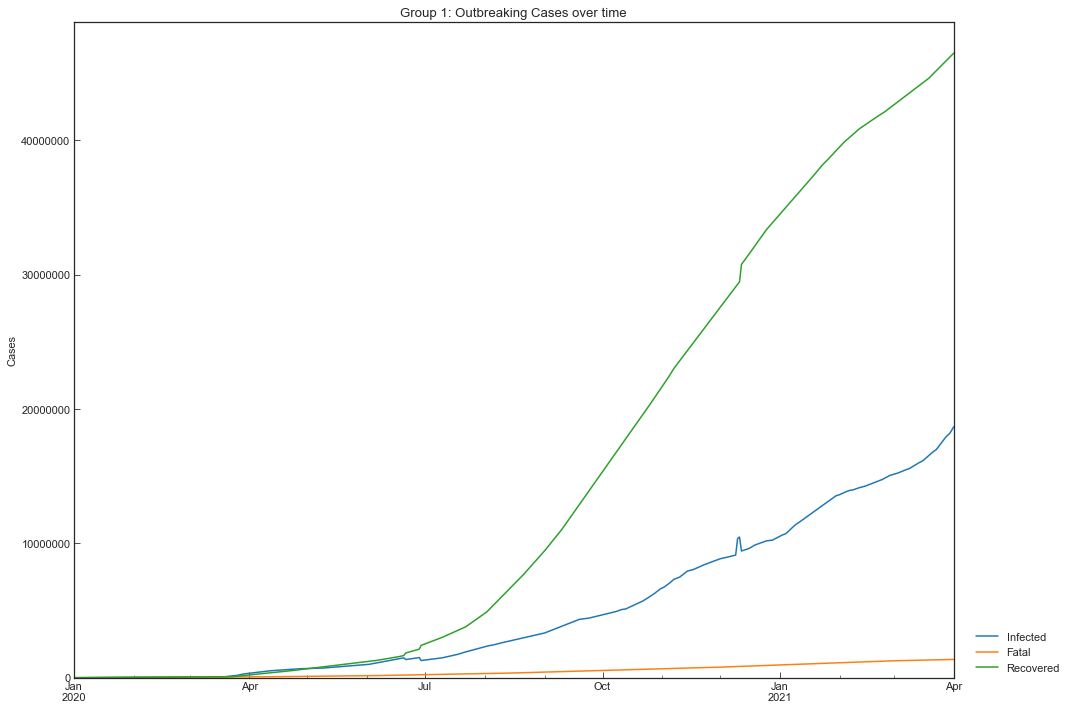

,Infected,Fatal,Recovered
Date,,,
2021-03-28,17930824,1343667,45861403
2021-03-29,18038018,1347304,46019852
2021-03-30,18197789,1351066,46175230
2021-03-31,18446174,1354744,46326258
2021-04-01,18673226,1358382,46490025


In [31]:
df = covid_df.loc[covid_df["Group"] == "outbreaking", ["Date", *data_cols]]
df = df.groupby("Date").sum()
df = df.iloc[:-1,:]
if not df.empty:
    cs.line_plot(df,"Group 1: Outbreaking Cases over time", y_integer=True)
df.tail()

### Grouping Stopping Country

In [32]:
growth_df[growth_df["Group"]=="Stopping"].head()

Date,Group,GrowthFactor>1[straight days],GrowthFactor<1[straight days],27Mar2021,28Mar2021,29Mar2021,30Mar2021,31Mar2021,01Apr2021,02Apr2021
Country,,,,,,,,,,
Gabon,Stopping,0,243,0.71,0.57,0.57,0.57,0.57,0.57,0.57
Oman,Stopping,0,205,0.78,0.78,0.77,0.81,0.83,0.79,0.79
Equatorial Guinea,Stopping,0,181,0.57,0.57,0.57,0.57,0.57,0.71,0.57
Costa Rica,Stopping,0,173,0.71,0.71,0.71,0.71,0.71,0.71,0.71
El Salvador,Stopping,0,162,0.71,0.71,0.86,0.71,0.71,0.86,0.86


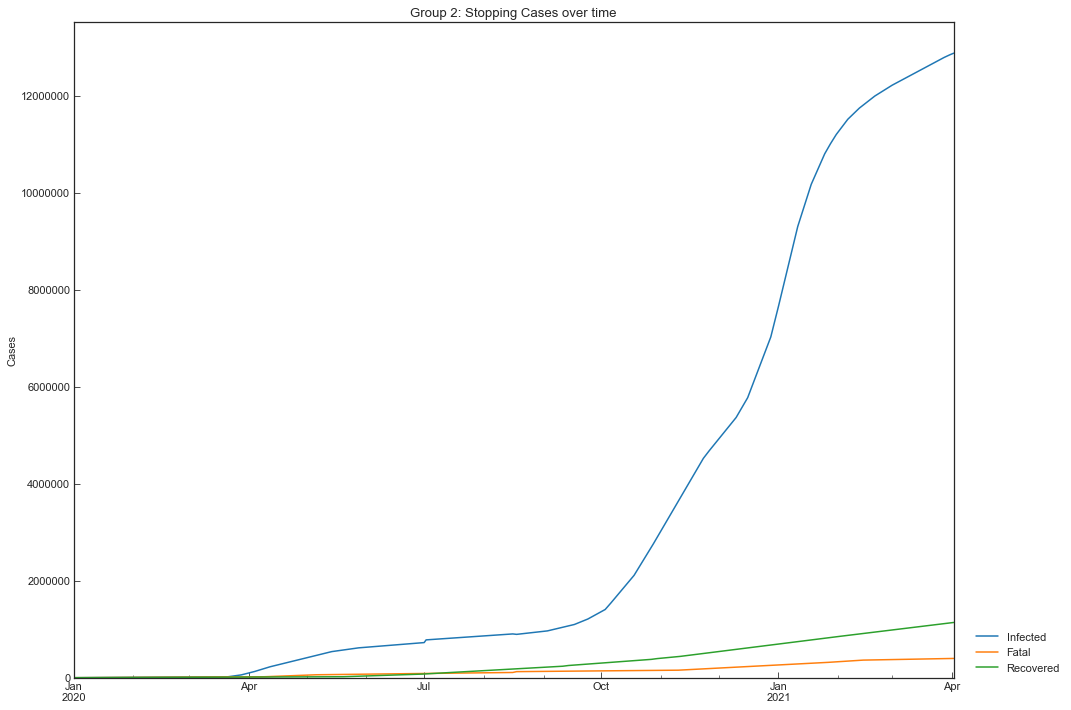

,Infected,Fatal,Recovered
Date,,,
2020-01-01,0,0,0
2020-01-02,0,0,0
2020-01-03,0,0,0
2020-01-04,0,0,0
2020-01-05,0,0,0


In [33]:
df = covid_df.loc[covid_df["Group"] == "Stopping", ["Date", *data_cols]]
df = df.groupby("Date").sum()
if not df.empty:
    cs.line_plot(df,"Group 2: Stopping Cases over time", y_integer=True)
df.head()

### Grouping crossroad Countries

In [34]:
growth_df[growth_df["Group"]=="Crossroad"]

Date,Group,GrowthFactor>1[straight days],GrowthFactor<1[straight days],27Mar2021,28Mar2021,29Mar2021,30Mar2021,31Mar2021,01Apr2021,02Apr2021
Country,,,,,,,,,,
Barbados,Crossroad,6,0,0.94,1.30,1.27,1.23,1.33,1.23,1.10
Monaco,Crossroad,6,0,0.94,1.06,1.09,1.23,1.18,1.37,1.19
New Zealand,Crossroad,6,0,0.63,2.06,2.09,2.09,2.26,2.19,2.24
Saint Vincent and the Grenadines,Crossroad,6,0,0.79,1.86,1.73,1.59,1.59,1.37,1.30
Togo,Crossroad,6,0,1.00,1.07,1.01,1.36,1.36,1.36,1.30
...,...,...,...,...,...,...,...,...,...,...
Tajikistan,Crossroad,0,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00
Tanzania,Crossroad,0,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00
Thailand,Crossroad,0,0,1.52,1.55,1.50,0.89,0.99,0.88,1.00


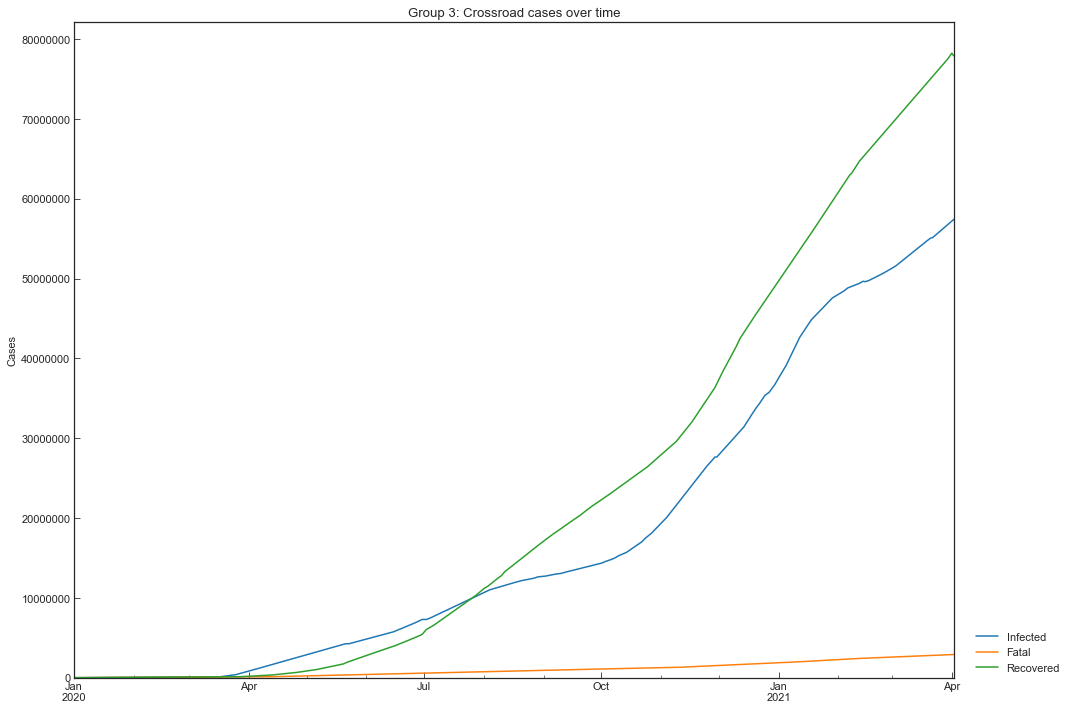

,Infected,Fatal,Recovered
Date,,,
2021-03-29,56658026,2864968,77233221
2021-03-30,56868076,2878542,77536939
2021-03-31,57056343,2893385,77918306
2021-04-01,57353053,2907332,78230305
2021-04-02,57400190,2904550,77892214


In [35]:
df = covid_df.loc[covid_df['Group']=="Crossroad",["Date",*data_cols]].groupby("Date").sum()

if not df.empty:
    cs.line_plot(df, "Group 3: Crossroad cases over time", y_integer=True)
df.tail()

### SIR Model

 The SIR epidemic model is a simple mathematical description of the spread of disease in a population. It divides the population into 3 compartments which may vary as a fucntion of time t, and space x:
 
 S(t) = are those who are susceptible but not infected yet.
 I(t) = are those who are infected.
 R(t) = are those who have recovered from the disease and now have immunity to it.
 
 The SIR model describes the changes in the population of each of three compartments using &beta; and &gamma;. &beta; describes the effective contact rate of the disease. &gamma; describes the mean recovery rate. An infected individual comes into contact with &beta;N other individuals per unit time (of which the fraction that are a susceptible to contracting the disease of S/N). 1/&gamma; is the mean period of time during which an infected individual can pass it on.
 
 
 
 The differential equations describing this model were first derived by Kermack and McKendrick:
 
 dS/dT = &beta;SI/N </br>
 dI/dT = &beta;SI/N - &gamma;I  </br>
 dR/dT = &gamma;I </br>
 
 N = S+I+R is the total population, T is the elapsed time from the start date.

#### Non-dimensional SIR Model

To make our model we will remove the units of the variable from ODE.
set (S,I,R) = N x (x,y,z) and (T, &beta;, &gamma;) = (&tau;t, &tau;<sup>-1</sup>&rho;, &tau;<sup>-1</sup>&sigma;)

This results in the ODE

dx/dt = -&rho;xy </br>
dy/dt = &rho;xy - &sigma;y </br>
dz/dt = &sigma;y

where N is the total population and &tau; is coefficient ([min], is an integer to simplify)

The range of variables and parameters:

0 <= (x,y,z,&rho;,&sigma;) <=1 </br>
1<= &tau; <= 1440

Basic reproduction number, Non-dimensional parameter, is defined as

R<sub>o</sub> = &rho;&sigma;<sup>-1</sup> = &beta;&gamma;<sup>-1</sup>

Estimated Mean Values of R<sub>o</sub>: R<sub>o</sub> means "the average number of secondary infections caused by an infected host"

In [36]:
# this is example data to simulate the SIR Model with tau = 1440 (max) and start date 01Jan2020

example_data = cs.ExampleData(tau=1440,start_date='01Jan2020')
example_data.cleaned()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered


In [37]:
# Model name
print(cs.SIR.NAME)
# Example parameter values
pprint(cs.SIR.EXAMPLE, compact=True)

SIR
{'param_dict': {'rho': 0.2, 'sigma': 0.075},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal or Recovered': 0, 'Infected': 1000, 'Susceptible': 999000}}


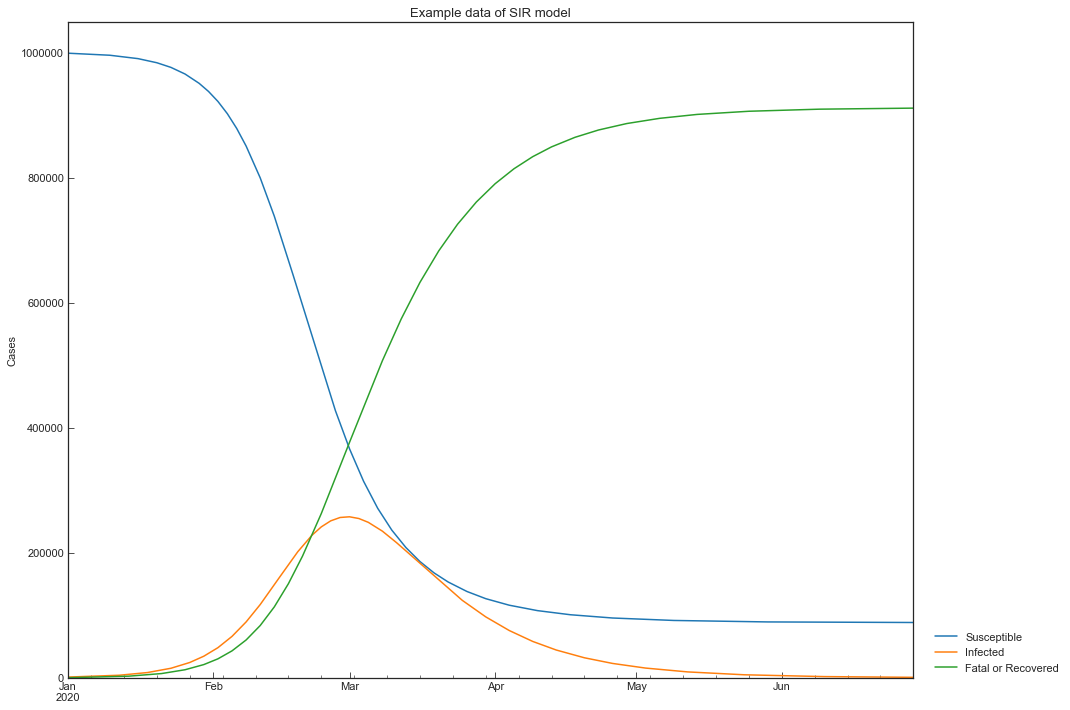

In [38]:
model = cs.SIR
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(
    df.set_index("Date"),
    title=f"Example data of {model.NAME} model",
    y_integer=True
)


 There is an inflection point of number of currently infected cases per total population(y). At this point value of susceptible cases (x) per total population is nearly equal to 1/&rho;

In [39]:
eg_r0 = model(model.EXAMPLE["population"], **model.EXAMPLE["param_dict"]).calc_r0()
df = example_data.specialized(model, **area)
x_max = df.loc[df["Infected"].idxmax(), "Susceptible"] / cs.SIR.EXAMPLE["population"]
(x_max, 1/eg_r0)

(0.366211, 0.37453183520599254)

### SIR model Implementation

We'll use differential equations to calculate the population change over time.

In [40]:
# The differentail equation to define SIR Model:

def deriv(state, t, N, beta, gamma):
    
    S, I, R = state
    
    #change in S population over time
    dsdt = -beta * S* I / N
    #change in I population over time
    dIdt = beta * S * I / N - gamma * I
    #change in R population over time
    dRdt = gamma * I
    
    return dsdt, dIdt, dRdt

### Preparing data for the model

We'll start by taking only the canadian population as our data frame.

Effective contact rate is transmission rate * contact rate, so:
 - 5% transmission rate and 5 contacts a day is 0.05*5 = 0.25
 
Recovery rate is 1/day
 - 4 day recovery rate 1/4 = 0.25

R0 is 3.5
37057765


,susceptible,infected,recovered,day
0,3.705776e+07,1.000000,0.000000e+00,0
1,3.705776e+07,1.195508,7.820330e-02,1
2,3.705776e+07,1.429240,1.716960e-01,2
3,3.705776e+07,1.708668,2.834673e-01,3
4,3.705776e+07,2.042727,4.170908e-01,4
...,...,...,...,...
368,1.260529e+06,1.516762,3.579723e+07,368
369,1.260529e+06,1.424260,3.579723e+07,369
370,1.260529e+06,1.337401,3.579723e+07,370
371,1.260529e+06,1.255838,3.579723e+07,371


<Figure size 1080x720 with 0 Axes>

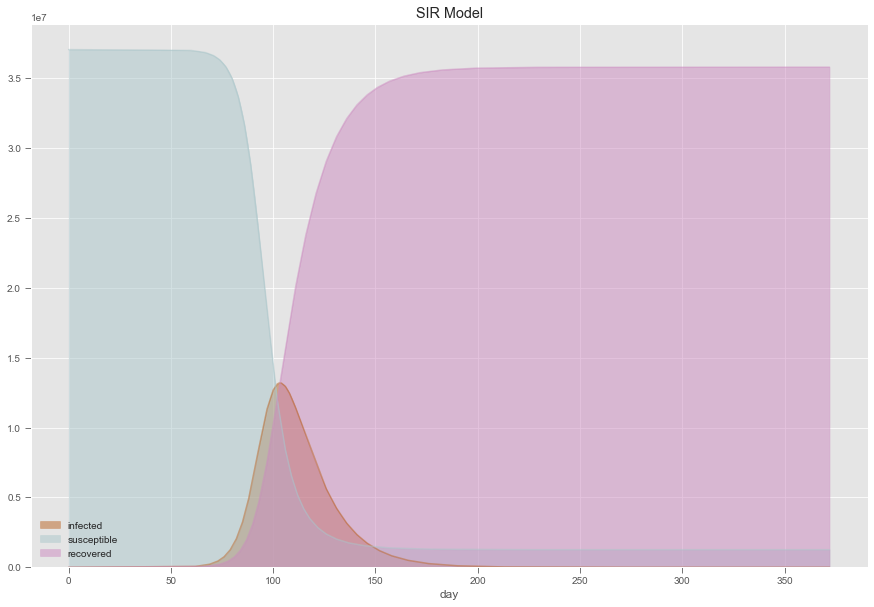

In [41]:
effective_contact_rate = 0.25
recovery_rate = 1/14

#calculate R0
print("R0 is", effective_contact_rate/recovery_rate)
total_population = population_data.value("Canada", province = None)
print(total_population)
recovered = 0
infected = 1
susceptible = total_population - infected - recovered

# number of days
# days = len(jhu_data.subset("Canada", province=None))
days = range(0,len(jhu_data.subset("Canada", province=None)))

#use of differentail equation

ret = odeint(deriv,
            [susceptible, infected, recovered],
            days,
            args = (total_population, effective_contact_rate, recovery_rate))

S, I , R = ret.T

#Build a dataframe

df = pd.DataFrame({
    'susceptible': S,
    'infected': I,
    'recovered': R,
    'day': days
})

plt.style.use('ggplot')
plt.figure(figsize=(15,10))
df.plot(x='day',
        y=['infected', 'susceptible', 'recovered'],
        color=['#bb6424', '#aac6ca', '#cc8ac0'],
        kind='area',
        stacked=False)
plt.title("SIR Model")
df

### Infected and Recovered

- Lets take a look at Infected and Recovered

Total population is 37057765


,susceptible,infected,recovered,day
0,37053786,3749,230,0
1,37053143,4366,256,1
2,37052438,4825,502,2
3,37051571,5672,522,3
4,37050430,6267,1068,4
...,...,...,...,...
368,36108946,45212,903607,368
369,36104094,46394,907277,369
370,36098614,47858,911293,370
371,36092849,49568,915348,371


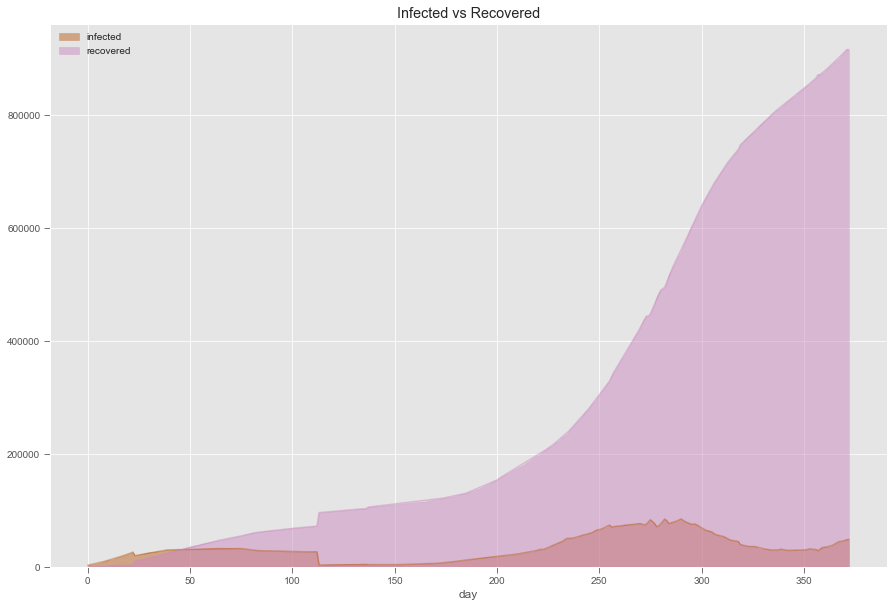

In [42]:
canada_subset = jhu_data.subset("Canada", province=None)
# canada_subset.head()


#total population
total_population = population_data.value("Canada", province = None)
print("Total population is", total_population)
#susceptible  = Total_population - infected - recovered

canada_subset["Susceptible"] = total_population - canada_subset["Infected"] - canada_subset["Recovered"]
canada_subset['day'] = range(0,len(canada_subset))

SIR_Model_subset = canada_subset[["Susceptible","Infected", "Recovered", "day"]]
SIR_Model_subset.columns = map(str.lower, SIR_Model_subset.columns)

SIR_Model_subset.plot(x='day',
        y=['infected','recovered'],
        color=['#bb6424', '#cc8ac0'],
        kind='area',
        stacked=False)
plt.title('Infected vs Recovered')
SIR_Model_subset

### SIR-D Model

As we are measuring the number of fatal cases and recovered cases separately, we will use recovered and deaths separately.

 The SIR-D epidemic model is also a simple mathematical description of the spread of disease in a population. It divides the population into 4 compartments which may vary as a fucntion of time t, and space x:
 
 S(t) = are those who are susceptible but not infected yet.
 I(t) = are those who are infected.
 R(t) = are those who have recovered from the disease and now have immunity to it.
 D(t) = those who died
 
 The SIR-D model describes the changes in the population of each of 4 compartments using &beta; and &gamma;. &alpha; describes the effective contact rate of the disease. &gamma; describes the mean recovery rate. &alpha; describes the number of Mortality rate. An infected individual comes into contact with &beta;N other individuals per unit time (of which the fraction that are a susceptible to contracting the disease of S/N). 1/&gamma; is the mean period of time during which an infected individual can pass it on.
 
 
 
 The differential equations describing this model:
 
 dS/dT = &beta;SI/N </br>
 dI/dT = &beta;SI/N - &gamma;+&alpha;I  </br>
 dR/dT = &gamma;I </br>
 dR/dT = &alpha;I </br>
 
 N = S+I+R+D is the total population, T is the elapsed time from the start date.

In [43]:
# The differentail equation to define SIR-D Model:

def derivSIRD(state, t, N, beta, gamma, alpha):
    
    S, I, R, D = state
    
    #change in S population over time
    dsdt = -beta * S* I / N
    #change in I population over time
    dIdt = beta * S * I / N - (gamma+alpha) * I
    #change in R population over time
    dRdt = gamma * I
    #change in Fatalities over time
    dDdt =  alpha * I
    
    return dsdt, dIdt, dRdt, dDdt

We'll start by taking only the canadian population as our data frame.

Effective contact rate is transmission rate * contact rate, so:
 - 5% transmission rate and 5 contacts a day is 0.05*5 = 0.25
 
Recovery rate is 1/day
 - 4 day recovery rate 1/4 = 0.25
 
Mortality rate is 1/day
 - mortality rate for canada is 2.5% (<a href="https://coronavirus.jhu.edu/data/mortality">"Mortality Rate for Countries"</a>)

R0 is 3.5
37057765


,susceptible,infected,recovered,fatal,day
0,3.705776e+07,1.000000,0.000000e+00,4.000000e+01,0
1,3.705776e+07,1.165991,7.720514e-02,4.002702e+01,1
2,3.705776e+07,1.359535,1.672257e-01,4.005853e+01,2
3,3.705776e+07,1.585206,2.721888e-01,4.009527e+01,3
4,3.705776e+07,1.848336,3.945748e-01,4.013810e+01,4
...,...,...,...,...,...
368,3.556141e+06,0.268248,2.481602e+07,8.685646e+06,368
369,3.556141e+06,0.249504,2.481602e+07,8.685646e+06,369
370,3.556141e+06,0.232070,2.481602e+07,8.685646e+06,370
371,3.556141e+06,0.215853,2.481602e+07,8.685646e+06,371


<Figure size 1080x720 with 0 Axes>

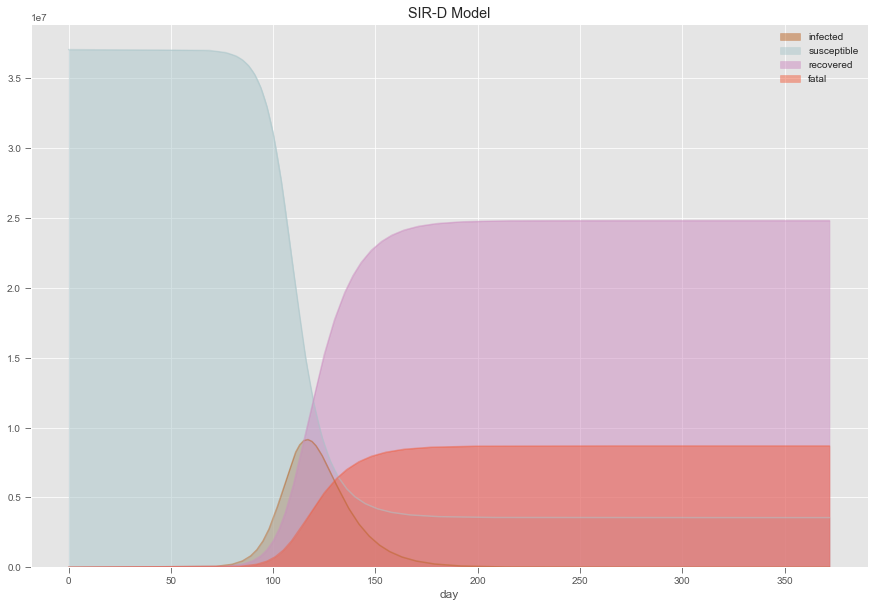

In [44]:
effective_contact_rate = 0.25
recovery_rate = 1/14
mortality_rate = 0.025

#calculate R0
print("R0 is", effective_contact_rate/recovery_rate)
total_population = population_data.value("Canada", province = None)
print(total_population)
recovered = 0
infected = 1
susceptible = total_population - infected - recovered
fatal = 40

# number of days
# days = len(jhu_data.subset("Canada", province=None))
days = range(0,len(jhu_data.subset("Canada", province=None)))

#use of differentail equation

ret = odeint(derivSIRD,
            [susceptible, infected, recovered, fatal],
            days,
            args = (total_population, effective_contact_rate, recovery_rate, mortality_rate))

S, I , R, D = ret.T

#Build a dataframe

df = pd.DataFrame({
    'susceptible': S,
    'infected': I,
    'recovered': R,
    'fatal': D,
    'day': days
})

plt.style.use('ggplot')
plt.figure(figsize=(15,10))
df.plot(x='day',
        y=['infected', 'susceptible', 'recovered', 'fatal'],
        color=['#bb6424', '#aac6ca', '#cc8ac0', '#F15E3F'],
        kind='area',
        stacked=False)
plt.title("SIR-D Model")
df

### Lets take a look at infected and fatal

Total population is 37057765


,susceptible,infected,fatal,recovered,day
0,37053786,3749,39,230,0
1,37053143,4366,53,256,1
2,37052438,4825,59,502,2
3,37051571,5672,61,522,3
4,37050430,6267,89,1068,4
...,...,...,...,...,...
368,36108946,45212,22900,903607,368
369,36104094,46394,22926,907277,369
370,36098614,47858,22959,911293,370
371,36092849,49568,23002,915348,371


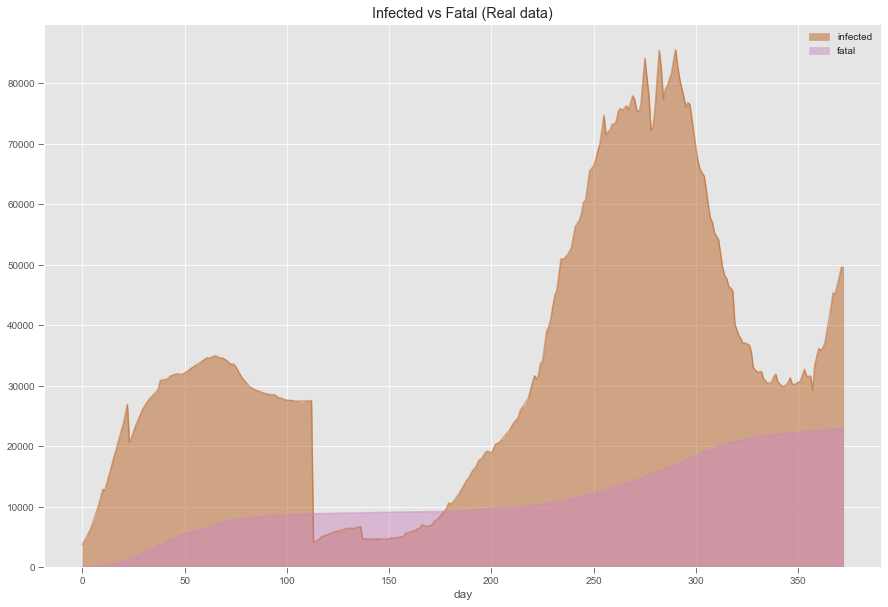

In [45]:
canada_subset = jhu_data.subset("Canada", province=None)
# canada_subset.head()


#total population
total_population = population_data.value("Canada", province = None)
print("Total population is", total_population)
#susceptible  = Total_population - infected - recovered

canada_subset["Susceptible"] = total_population - canada_subset["Infected"] - canada_subset["Recovered"]
canada_subset['day'] = range(0,len(canada_subset))

SIR_Model_subset = canada_subset[["Susceptible","Infected","Fatal", "Recovered", "day"]]
SIR_Model_subset.columns = map(str.lower, SIR_Model_subset.columns)
# print(SIR_Model_subset.head())

SIR_Model_subset.plot(x='day',
        y=['infected','fatal'],
        color=['#bb6424', '#cc8ac0'],
        kind='area',
        stacked=False)
plt.title("Infected vs Fatal (Real data)")
SIR_Model_subset

### SIR-F Model

Initially many cases were confirmed after they died in case of COVID-19. To take this into consideration we will add S*: confirmed and uncategorized.

 - S: Suceptible (Population - confirmed)
 - S*: Confirmed and uncategorized
 - I: Confirmed and categorized as Infected
 - R: Confirmed and categorized as Recovered
 - F: Confirmed and categorized as Fatal
 
 we are measuring these below mentioned variables:
 
 Confirmed = I+R+F
 Recovered = R
 Deaths = F
 
 The mathematical model describing these equations are:
 
 dS/dT = &beta;SI/N </br>
 dI/dT = &beta;SI*(1-&alpha;<sub>1</sub>)/N - &gamma;+(&alpha;<sub>2</sub>)* I  </br>
 dR/dT = &gamma;I </br>
 dF/dT =  (&alpha;<sub>1</sub>&beta;SI)/N + (&alpha;<sub>2</sub>)* I </br>
 
 When &alpha;<sub>1</sub> = 0, SIR-F model is the same as SIR-D model.
 
 &alpha;<sub>1</sub>: Probability of direct fatality
 &alpha;<sub>2</sub>: Moratality rate
 &beta; Effective contact rate
 &gamma; Recovery rate
 
 The value of  &alpha;<sub>1</sub> is very small because performance of PCR tesets were improved significantly
 
 Some important notes on S*:
 S* describes those cases who were actually the carriers of the disease, who either die and were confirmed positive after their death or were moved to infected after being confirmed. In our JHU dataset we know the COVID-19 confirmed cases, but we don't know about the cases who died without it. &alpha;<sub>1</sub> is small at this time and our new SIR-F model can be taken as an enhanced model of SIR-D model.

 
 

In [46]:
# The differentail equation to define SIR-F Model:

def derivSIRF(state, t, N, beta, gamma, alpha1, alpha2):
    
    S, I, R, F = state
    
    #change in S population over time
    dsdt = -beta * S* I / N
    #change in I population over time
    dIdt = (beta * S * I*(1 - alpha1) / N) - ((gamma+alpha2) * I)
    #change in R population over time
    dRdt = gamma * I
    #change in Fatalities over time
    dFdt = (beta * S* I*alpha1 / N) + alpha2 * I
    
    return dsdt, dIdt, dRdt, dFdt

R0 is 3.5
37057765


,susceptible,infected,recovered,fatal,day
0,3.705776e+07,1.000000,0.000000e+00,4.000000e+01,0
1,3.705776e+07,1.165962,7.720415e-02,4.002705e+01,1
2,3.705776e+07,1.359467,1.672213e-01,4.005859e+01,2
3,3.705776e+07,1.585087,2.721778e-01,4.009536e+01,3
4,3.705776e+07,1.848151,3.945531e-01,4.013823e+01,4
...,...,...,...,...,...
368,3.557251e+06,0.268872,2.481271e+07,8.687840e+06,368
369,3.557251e+06,0.250086,2.481271e+07,8.687840e+06,369
370,3.557251e+06,0.232612,2.481271e+07,8.687840e+06,370
371,3.557251e+06,0.216359,2.481271e+07,8.687840e+06,371


<Figure size 1080x720 with 0 Axes>

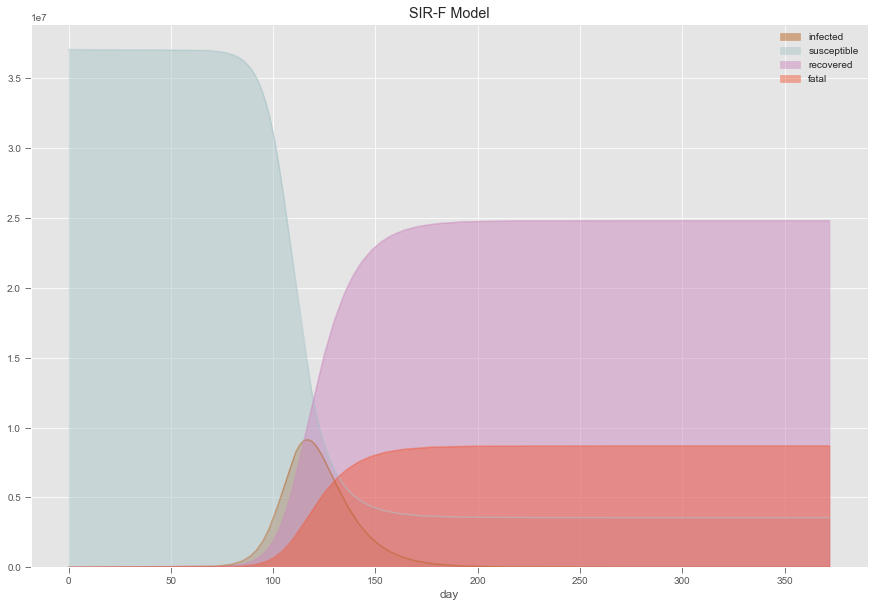

In [47]:
effective_contact_rate = 0.25
recovery_rate = 1/14
probability_of_direct_fatality = 0.0001
mortality_rate = 0.025

#calculate R0
print("R0 is", effective_contact_rate/recovery_rate)
total_population = population_data.value("Canada", province = None)
print(total_population)
recovered = 0
infected = 1
susceptible = total_population - infected - recovered
fatal = 40

# number of days
# days = len(jhu_data.subset("Canada", province=None))
days = range(0,len(jhu_data.subset("Canada", province=None)))

#use of differentail equation

ret = odeint(derivSIRF,
            [susceptible, infected, recovered, fatal],
            days,
            args = (total_population, effective_contact_rate, recovery_rate, probability_of_direct_fatality, mortality_rate))

S, I , R, F = ret.T

#Build a dataframe

df = pd.DataFrame({
    'susceptible': S,
    'infected': I,
    'recovered': R,
    'fatal': F,
    'day': days
})

plt.style.use('ggplot')
plt.figure(figsize=(15,10))
df.plot(x='day',
        y=['infected', 'susceptible', 'recovered', 'fatal'],
        color=['#bb6424', '#aac6ca', '#cc8ac0', '#F15E3F'],
        kind='area',
        stacked=False)
plt.title("SIR-F Model")
df

### Example of non-dimensional SIR-F model.
<img src="../Images/nondimensionalsir.PNG"></img>
#### So now our model is built and we know how all the compartments influence each other. We will now use covsirphy package to explore the SIR-F model.
To know more about CovsirPhy<a herf="https://github.com/lisphilar/covid19-sir "> Click here </a>

In [48]:
# model name
print(cs.SIRF.NAME)
# parameter values
pprint(cs.SIRF.EXAMPLE, compact=True)

SIR-F
{'param_dict': {'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075, 'theta': 0.002},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal': 0,
             'Infected': 1000,
             'Recovered': 0,
             'Susceptible': 999000}}


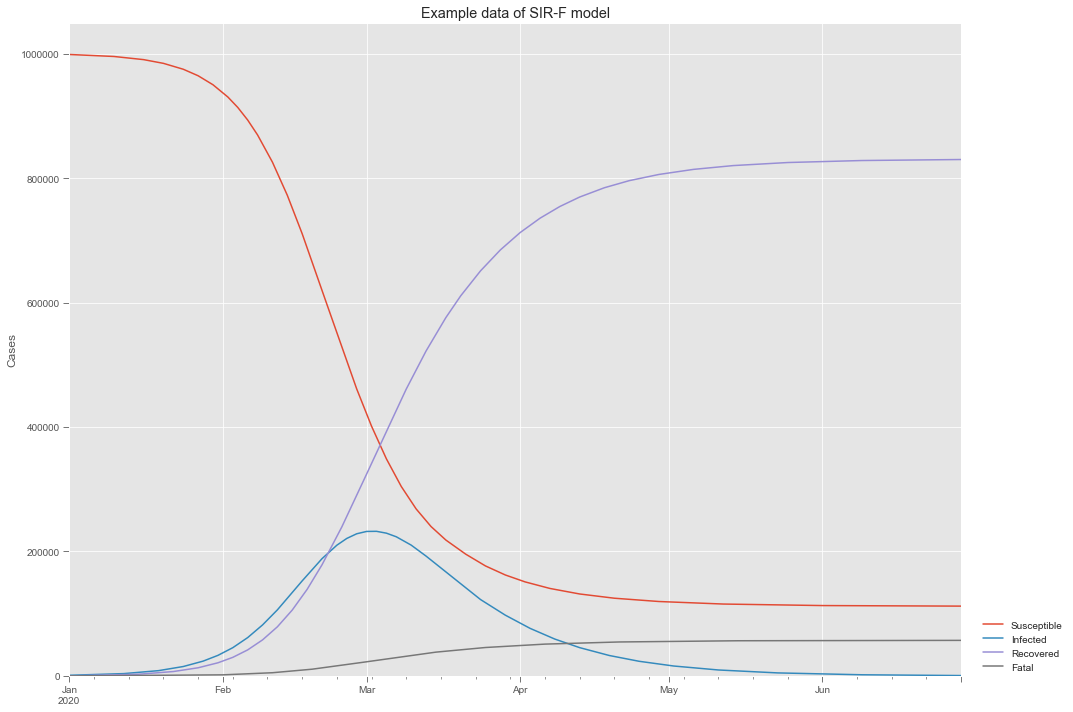

In [49]:
model = cs.SIRF
area = {"country":"Full","province":model.NAME}

# adding records
example_data.add(model,**area)

## creating record
df = example_data.specialized(model, **area)
cs.line_plot(
    df.set_index("Date"),
    title=f"Example data of {model.NAME} model",
    y_integer=True
)

The inflection point of y number of currently infected cases per total population and x the number of susceptible cases per total population is nearly equal to 1/R0.

In [50]:
eg_r0 = model(model.EXAMPLE["population"], **model.EXAMPLE['param_dict']).calc_r0()
df = example_data.specialized(model, **area)
x_max = df.loc[df["Infected"].idxmax(), "Susceptible"] / cs.SIR.EXAMPLE["population"]
(x_max, 1/eg_r0)

(0.401442, 0.4)

### Hyperparameter optimization using optuna package

In [51]:
# Example data setting population
population_data.update(cs.SIRF.EXAMPLE["population"],**area)
population_data.value(**area)

1000000

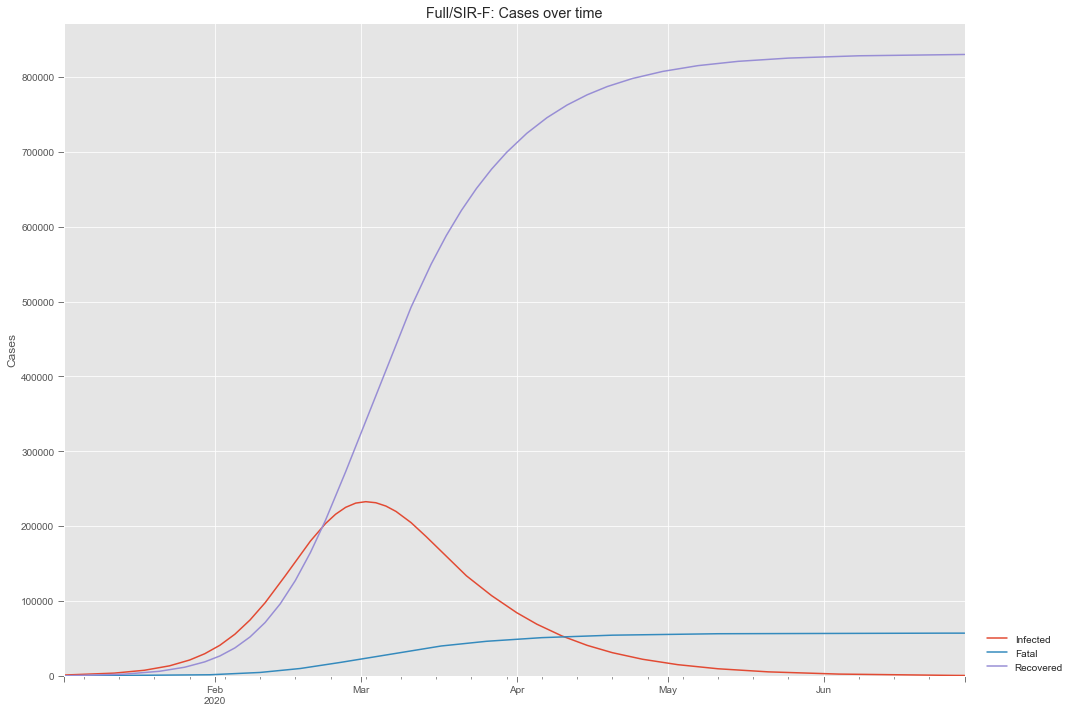

In [52]:
#JHU-style records

sirf_snl = cs.Scenario(example_data, population_data, tau=1440, **area)
_ = sirf_snl.records()

In [53]:
# Parameter estimation

sirf_snl.add().summary()
sirf_snl.estimate(cs.SIRF, timeout=120)


<SIR-F model: parameter estimation>
Running optimization with 12 CPUs...
Completed optimization. Total: 2 min  4 sec


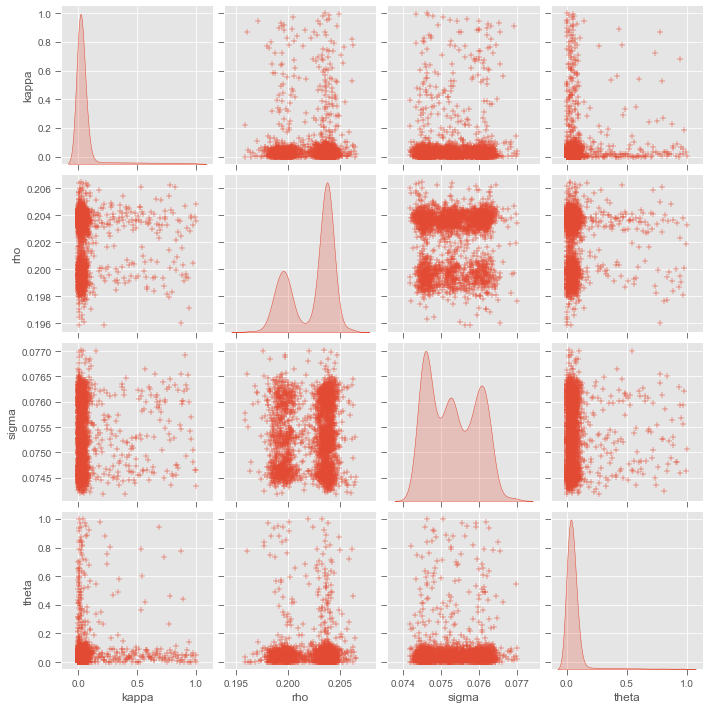

In [54]:
# distribution of variables

sirf_snl.estimate_history("0th")

In [55]:
# table for estimated values

df = sirf_snl.summary()
setting_model = cs.SIRF(population=cs.SIRF.EXAMPLE["population"],**cs.SIRF.EXAMPLE["param_dict"])

setting_dict = {
    "Population": cs.SIRF.EXAMPLE["population"],
    "ODE":cs.SIRF.NAME,
    "Rt":setting_model.calc_r0(),
    "tau": 1440,
    **setting_model.calc_days_dict(1440),
    **cs.SIRF.EXAMPLE["param_dict"]
}

df = df.append(pd.Series(setting_dict, name="setting"))
df.fillna("-")

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],RMSLE,Trials,Runtime
0th,Past,02Jan2020,29Jun2020,1000000,SIR-F,2.56,0.019557,0.003262,0.203457,0.074732,1440,0.020,306,4,13,0.0972948,2458,2 min 0 sec
setting,-,-,-,1000000,SIR-F,2.50,0.002000,0.005000,0.200000,0.075000,1440,0.002,200,5,13,-,-,-


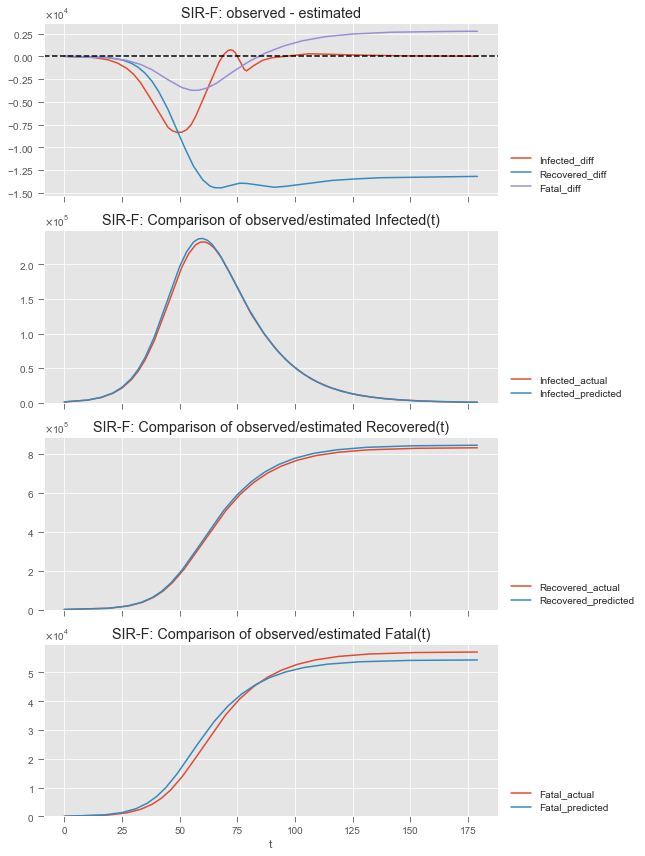

In [56]:
sirf_snl.estimate_accuracy("0th")

### Control factors of SIR-F model parameters

Here we will define the control factors for our example data. &tau;=1440, the start date is 01Jan2020, population is set to 1,000,000 and country name is "Theoretical". 

In [57]:
# Preset of SIR-F parameters

preset_dict = cs.SIRF.EXAMPLE["param_dict"]
preset_dict

{'theta': 0.002, 'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075}

In [58]:
area = {"country":"Theoritical"}
example_data.add(cs.SIRF, step_n=30, **area)

In [59]:
#Register population value
population_data.update(cs.SIRF.EXAMPLE["population"], **area)
population_data.value(**area)

1000000

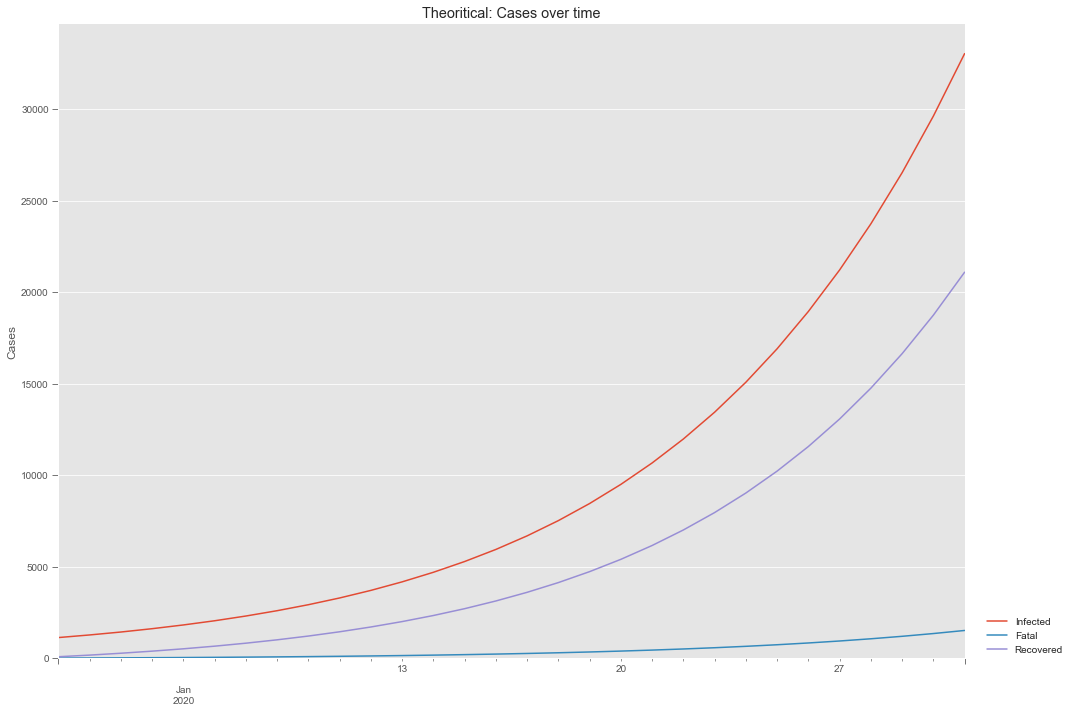

,Date,Infected,Fatal,Recovered
0,2020-01-02,1127,6,80
1,2020-01-03,1270,12,169
2,2020-01-04,1430,19,271
3,2020-01-05,1612,28,385
4,2020-01-06,1816,37,513


,Date,Infected,Fatal,Recovered
25,2020-01-27,21210,940,13068
26,2020-01-28,23730,1061,14753
27,2020-01-29,26524,1196,16637
28,2020-01-30,29616,1347,18741
29,2020-01-31,33030,1515,21088


In [60]:
# show records with scenario class

snl = cs.Scenario(example_data,population_data, tau=1440,**area)
record_df =snl.records()
display(record_df.head())
display(record_df.tail())

### Defining Control factors of effective contact rate &beta;<sub>1</sub> 

g<sub>s</sub>: Number of days susceptible person go out in a week.</br>
g<sub>w</sub>: Numbe of days waiting but un-quarantined persons go out.</br>
g<sub>i</sub>: Number of days currently infected but un-quarantined persons go out.</br>
q: Quarantine rate of currently infected cases.</br>
v: Probability of existance of virus.</br>
m: Rate of persons wearing masks effectively.</br>
w<sub>e</sub>: Washing hands.</br>
w<sub>n</sub>: Hand washing frequency.</br>
h<sub>1</sub>: HEalth condition of susceptible and contacted persons(cellular immunity).</br>
h<sub>2</sub>: Health condition of susceptible and contacted persons(humoral immunity).</br>
c: Number of contacts between patients and susceptible persons in a minute.</br>
&delta;: unkown factors</br>

<img src="../Images/mathematicaleequation.PNG"></img></br>
The above equations is derived from SEWIR-F model. For more info<a href="https://github.com/lisphilar/covid19-sir"> click here </a>. We are not working with SEIR models because for SEWIR-F predictions we need to calculate &rho;<sub>1</sub> and &rho;<sub>2</sub> with linelist dataset for each country which is very difficult. For more info on SEIR model visit <a href="http://indico.ictp.it/event/7960/session/3/contribution/19/material/slides/">click here</a>

#### Predicting the impact of lockdown by minimising the number of days a susceptible person goes out.

In [61]:
# beta value before any action was taken

rho_before = cs.SIRF.EXAMPLE["param_dict"]["rho"]
rho_before

0.2

Calculation of g<sub>s</sub> value before lockdown using population pyramid

In [62]:
going_out_df = go_out("Canada")
going_out_df

,Age_first,Age_last,Period_of_life,Days,Types,School,Office,Others,Age,Population,Portion
0,0,2,nursery,3,school,3,0,0,2,1193571,0.034264
1,3,5,nursery school,5,school,4,0,1,5,1193646,0.034266
2,6,10,elementary school,6,school,5,0,1,10,1987203,0.057047
3,11,13,middle school,6,school,5,0,1,13,1186425,0.034059
4,14,18,high school,7,school,6,0,1,18,2007971,0.057643
5,19,25,university/work,7,school/work,3,3,1,25,3365119,0.096603
6,26,35,work,6,work,0,6,1,35,5302920,0.152232
7,36,45,work,5,work,0,5,1,45,5012608,0.143898
8,46,55,work,5,work,0,5,1,55,4961567,0.142432
9,56,65,work,5,work,0,5,1,65,5165771,0.148294


In [63]:
gs_before = (going_out_df[["School","Office","Others"]].sum(axis=1)*going_out_df["Portion"]).sum()
gs_before

5.915772475744851

Calculation of g<sub>s</sub> value after lockdown assuming below mentioned conditions:
 - All schools were closed.
 - Offices were closed and only 50% of employee were working onsite
 - People will go out only 1 day instead of going to office, school
    

In [64]:
df = going_out_df.copy()
df.loc[df["School"]+df["Office"]>0, "Others"] +=1
df["School"] = 0
df["Office"] *= 0.5
going_out_after = df.copy()
going_out_after

,Age_first,Age_last,Period_of_life,Days,Types,School,Office,Others,Age,Population,Portion
0,0,2,nursery,3,school,0,0.0,1,2,1193571,0.034264
1,3,5,nursery school,5,school,0,0.0,2,5,1193646,0.034266
2,6,10,elementary school,6,school,0,0.0,2,10,1987203,0.057047
3,11,13,middle school,6,school,0,0.0,2,13,1186425,0.034059
4,14,18,high school,7,school,0,0.0,2,18,2007971,0.057643
5,19,25,university/work,7,school/work,0,1.5,2,25,3365119,0.096603
6,26,35,work,6,work,0,3.0,2,35,5302920,0.152232
7,36,45,work,5,work,0,2.5,2,45,5012608,0.143898
8,46,55,work,5,work,0,2.5,2,55,4961567,0.142432
9,56,65,work,5,work,0,2.5,2,65,5165771,0.148294


In [65]:
df = going_out_after.copy()
gs_after = (df[["School","Office","Others"]].sum(axis=1)*df["Portion"]).sum()
gs_after

3.7972982896326273

In [66]:
rho_after = rho_before * (gs_after/gs_before)
print(rho_after)
print(rho_after/rho_before)

0.12837878080003448
0.6418939040001723


In [67]:
# set 0th phase from 02Jan2020 to 31Jan2020 with preset parameter values
snl.clear(include_past=True)
snl.add(end_date="31Jan2020", model=cs.SIRF, **preset_dict)
snl.summary()
# Add main scenario after 31Dec2020
snl.add(end_date="31Dec2020", name="Main")
#Add Lockdown Scenario
snl.clear(include_past=False, name="Lockdown")
snl.add(end_date="31Dec2020", name="Lockdown", rho=rho_after).summary()

Type      Start        End  Population    ODE   Rt  theta  \
Scenario Phase                                                                
Main     0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.5  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  2.5  0.002   
Lockdown 0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.5  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  1.6  0.002   

                kappa       rho  sigma   tau  alpha1 [-]  1/alpha2 [day]  \
Scenario Phase                                                             
Main     0th    0.005  0.200000  0.075  1440       0.002             200   
         1st    0.005  0.200000  0.075  1440       0.002             200   
Lockdown 0th    0.005  0.200000  0.075  1440       0.002             200   
         1st    0.005  0.128379  0.075  1440       0.002             200   

                1/beta [day]  1/gamma [day]  
Scenario Phase                               
Main     0th               5             13  
         1st               5             13  
Lockdown 0th               5             13  
         1st               7             13

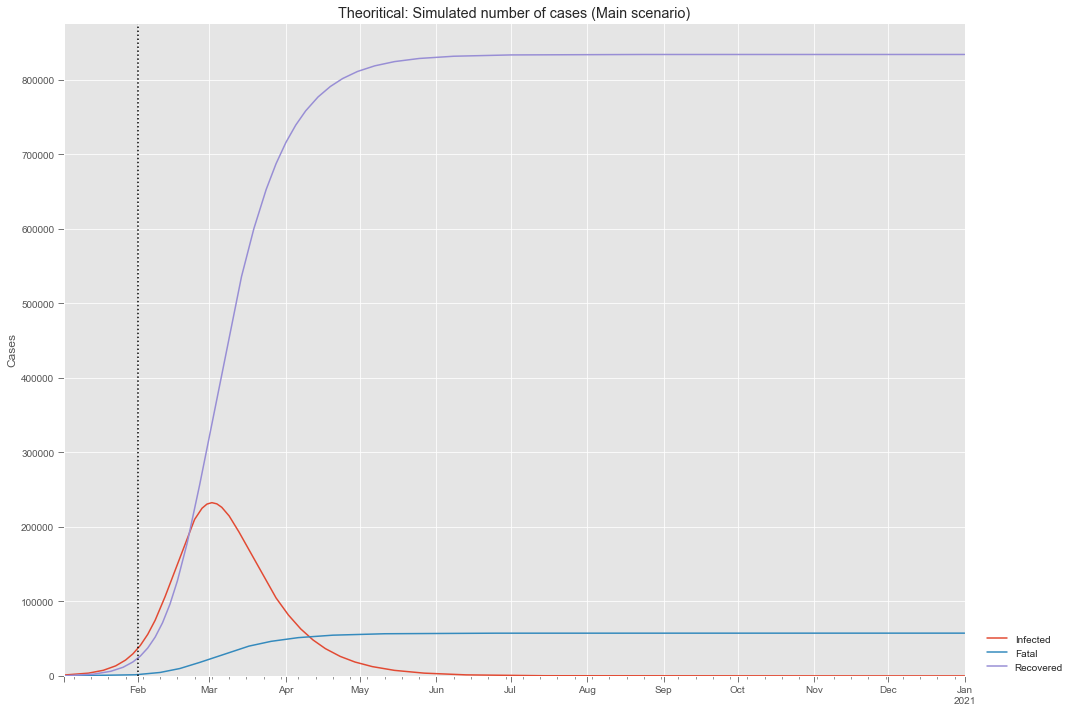

In [68]:
 _ = snl.simulate(name="Main")

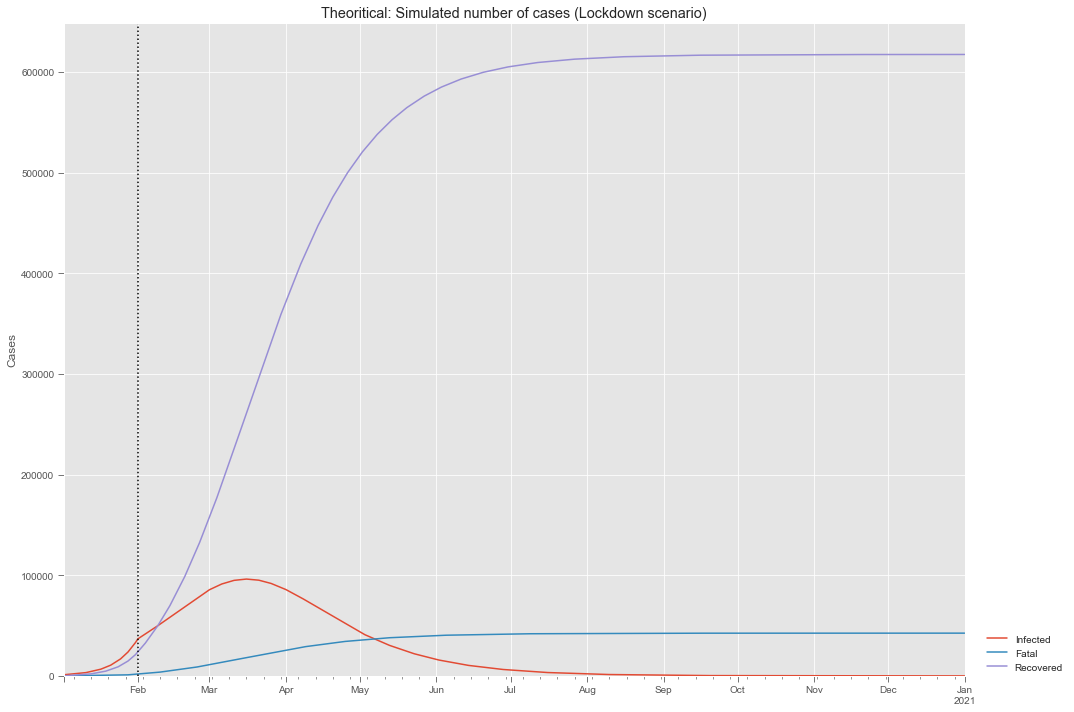

In [69]:
 _ = snl.simulate(name="Lockdown")

In [70]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 01Jan2021,Infected on 01Jan2021,Fatal on 01Jan2021,1st_Rt
Main,232568,02Mar2020,891643,0,57398,2.5
Lockdown,96224,16Mar2020,660040,7,42488,1.6


### S-R trend of actual data in Canada </br>
Plotting S-R trend

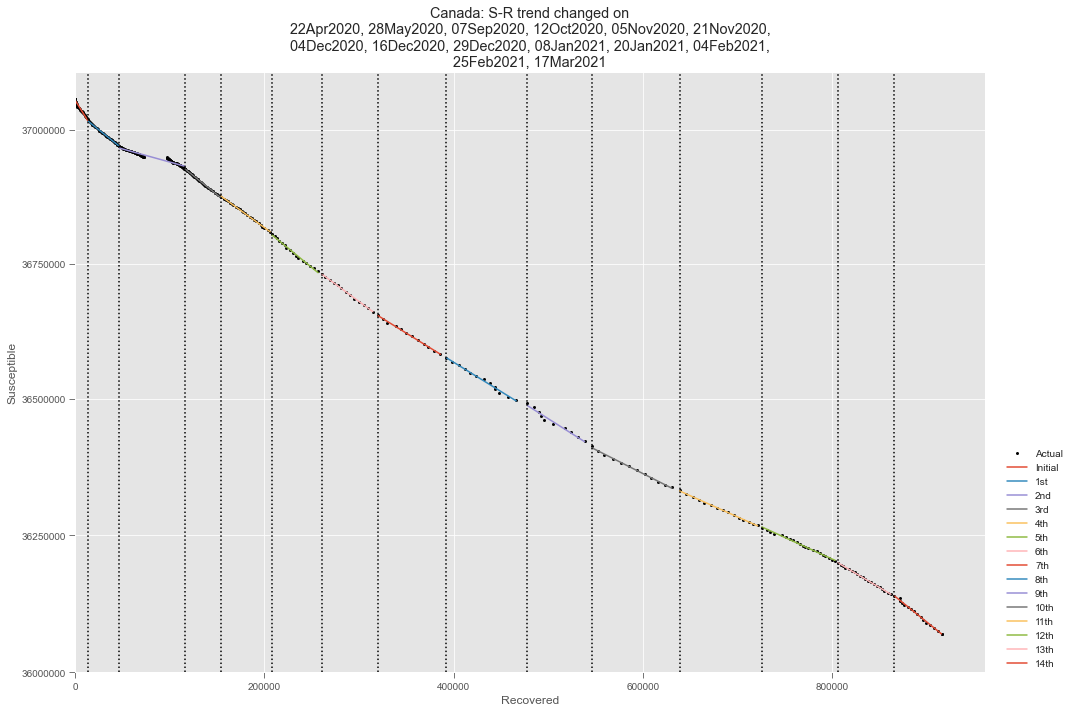

In [71]:
can_scenario = cs.Scenario(jhu_data, population_data, "Canada")
_ = can_scenario.trend()

 -  From this graph we can see that SIR-F parameters were changed at some time-points. Assuming that there are 4 change points in Canada dataset we will find time points for them.

### Scenario Analysis

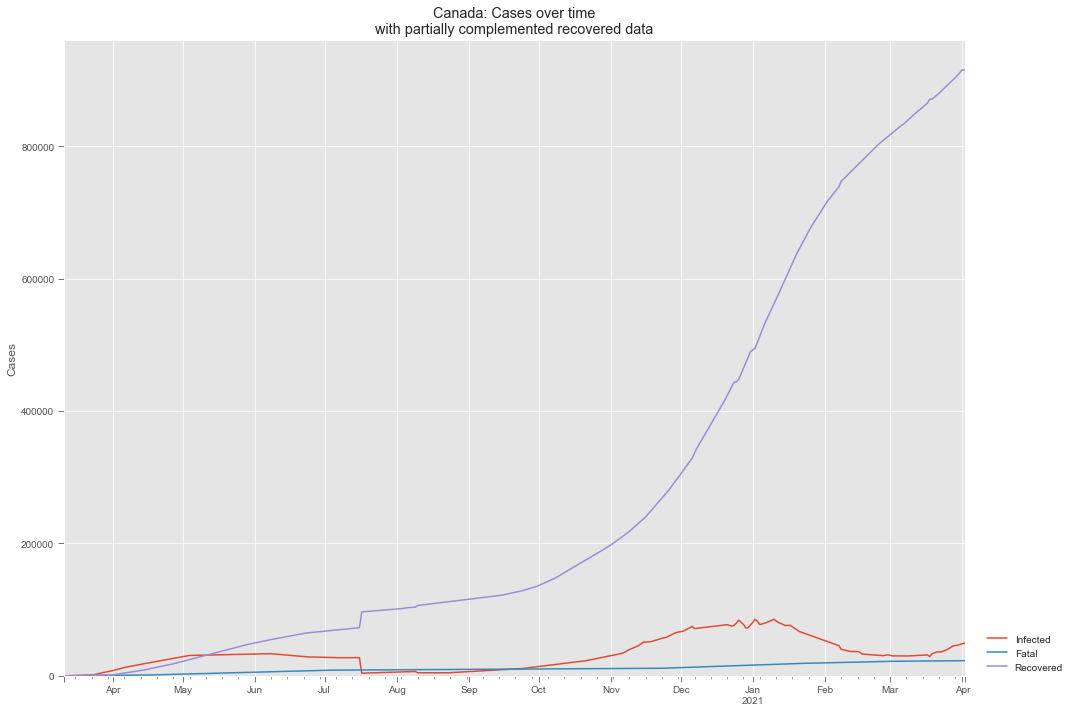

,Date,Infected,Fatal,Recovered
383,2021-03-29,45212,22900,903607
384,2021-03-30,46394,22926,907277
385,2021-03-31,47858,22959,911293
386,2021-04-01,49568,23002,915348
387,2021-04-02,49568,23002,915348


In [72]:
can_scenario.records().tail()

### Phases in Canada
Change points will be used as start date of phases. For each phase, we will apply SIR-F model. &tau; values will remain same.

In [73]:
can_scenario.summary()

,Type,Start,End,Population
0th,Past,11Mar2020,21Apr2020,37057765
1st,Past,22Apr2020,27May2020,37057765
2nd,Past,28May2020,06Sep2020,37057765
3rd,Past,07Sep2020,11Oct2020,37057765
4th,Past,12Oct2020,04Nov2020,37057765
5th,Past,05Nov2020,20Nov2020,37057765
6th,Past,21Nov2020,03Dec2020,37057765
7th,Past,04Dec2020,15Dec2020,37057765
8th,Past,16Dec2020,28Dec2020,37057765
9th,Past,29Dec2020,07Jan2021,37057765


### Estimate SIR-F parameters

In [74]:
can_scenario.estimate(cs.SIRF, timeout=150)


<SIR-F model: parameter estimation>
Running optimization with 12 CPUs...
	10th phase (17Mar2021 - 02Apr2021): finished 1757 trials in 1 min 30 sec
Completed optimization. Total: 4 min 39 sec


### Compare parameters

In [75]:
can_scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/gamma [day],1/beta [day],1/alpha2 [day],alpha1 [-],RMSLE,Trials,Runtime
0th,Past,11Mar2020,21Apr2020,37057765,SIR-F,6.78,0.034481,0.000320,0.042211,0.005692,360,43,5,781,0.034,1.055565,1588,2 min 31 sec
1st,Past,22Apr2020,27May2020,37057765,SIR-F,1.34,0.078768,0.000327,0.012768,0.008456,360,29,19,763,0.079,0.051503,1885,2 min 30 sec
2nd,Past,28May2020,06Sep2020,37057765,SIR-F,0.41,0.084218,0.000082,0.004214,0.009240,360,27,59,3056,0.084,0.262894,1541,2 min 31 sec
3rd,Past,07Sep2020,11Oct2020,37057765,SIR-F,1.38,0.000443,0.000236,0.030477,0.021842,360,11,8,1057,0.000,0.029902,1591,2 min 31 sec
4th,Past,12Oct2020,04Nov2020,37057765,SIR-F,1.26,0.000121,0.000229,0.029118,0.022869,360,10,8,1093,0.000,0.014688,249,0 min 20 sec
5th,Past,05Nov2020,20Nov2020,37057765,SIR-F,1.59,0.001467,0.000281,0.024726,0.015204,360,16,10,890,0.001,0.025654,1597,2 min 30 sec
6th,Past,21Nov2020,03Dec2020,37057765,SIR-F,1.29,0.000433,0.000257,0.024110,0.018446,360,13,10,973,0.000,0.008732,1608,2 min 30 sec
7th,Past,04Dec2020,15Dec2020,37057765,SIR-F,1.11,0.000867,0.000368,0.022389,0.019757,360,12,11,679,0.001,0.010306,829,1 min 10 sec
8th,Past,16Dec2020,28Dec2020,37057765,SIR-F,1.11,0.018024,0.000005,0.022424,0.019868,360,12,11,54836,0.018,0.019936,368,0 min 30 sec
9th,Past,29Dec2020,07Jan2021,37057765,SIR-F,1.23,0.000574,0.000426,0.024516,0.019428,360,12,10,586,0.001,0.027432,370,0 min 30 sec


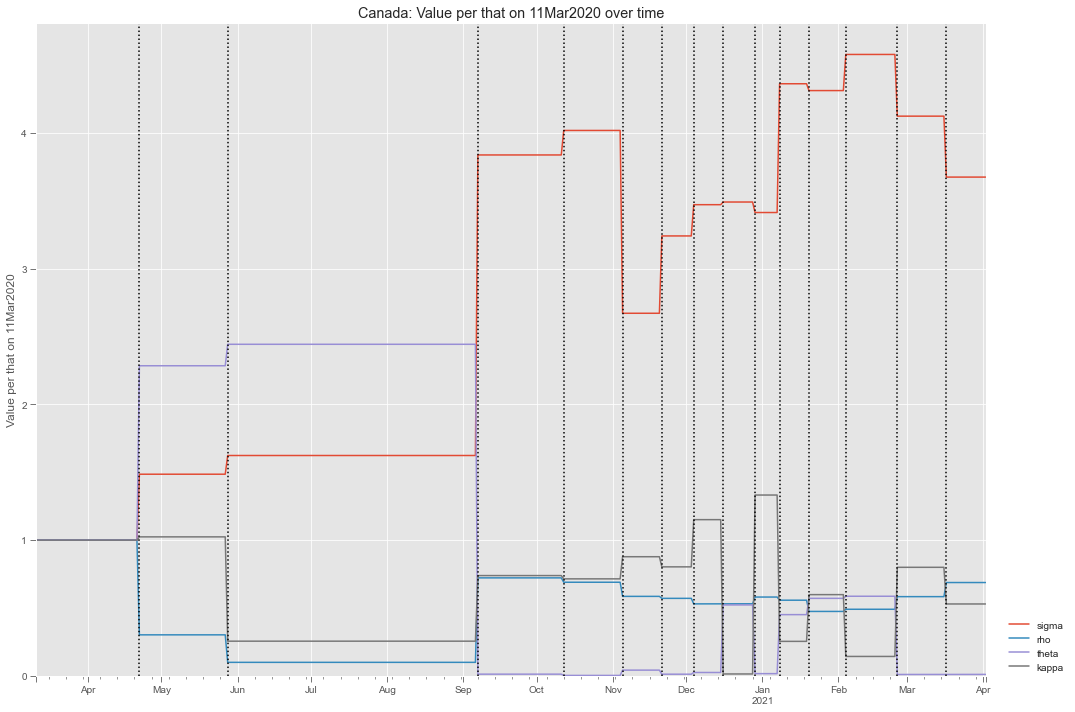

In [76]:
_ = can_scenario.history_rate()

In [77]:
canada_action_df = canada_action(canada_action_raw)
print("Measures taken in Canada")
canada_action_df[(canada_action_df["Jurisdiction "]=="Can.")&(canada_action_df["Intervention category"]=="Closures")]

Measures taken in Canada


,Entry ID,Jurisdiction,Level,Date announced,Date implemented,Intervention category,Intervention type,Who Implemented,What Implemented,Effective Until,Indigenous population group,Primary source
470,CAN034,Can.,Federal,2020-03-17,2020-03-19,Closures,Closures — recreation,Parks Canada,"Temporarily suspending all visitor services in all national parks, national historic sites and national marine conservation areas across the country",NaT,No,https://www.canada.ca/en/parks-canada/news/2020/03/parks-canada-temporarily-suspends-all-visitor-services-across-the-country-until-further-notice.html
653,CAN039,Can.,Federal,2020-03-24,2020-03-25,Closures,Closures — recreation,Parks Canada,"Temporarily suspending all motor vehicle access by visitors at all national parks, national historic sites and national marine conservation areas",NaT,No,https://www.pc.gc.ca/en/voyage-travel/securite-safety/covid-19-info
786,CAN052,Can.,Federal,2020-04-02,2020-04-02,Closures,Closures — non-essential services,Public Safety Canada,"Released a guidance document to assist various jurisdictions and businesses in their decision-making around the types of employees considered essential across Canada’s 10 critical infrastructure sectors: energy and utilities, information and communication technologies, finance, health, food, water, transportation, safety, government and manufacturing",NaT,No,https://www.canada.ca/en/public-safety-canada/news/2020/04/government-of-canada-provides-guidance-on-services-and-functions-deemed-essential-to-canadas-critical-infrastructure-during-covid-19.html
937,CAN016,Can.,Federal,2020-04-15,2020-04-15,Closures,Closures — recreation,Parks Canada,"Suspended camping, group activities and events at all national parks, national historic sites, heritage canals and national marine conservation areas",2020-06-21,No,https://www.canada.ca/en/parks-canada/news/2020/04/to-help-limit-the-spread-of-covid-19-parks-canada-suspends-camping-group-activities-and-events-across-the-country-until-at-least-may-31-2020.html


From the graph and measures taken from canada government it seems school closures and lockdown reduced th effective contact rate.

### Effect of school closure and lockdown

From the above table we can see that government of canada declared nationwide lockdown on 17Mar2020 and all the people were asked to remain home. From this we will predict the effect of closures after 3rd phase.

In [78]:
can_scenario.get("Start", name="Main", phase="3rd")

'07Sep2020'

### Value of control factors of &beta;<sub>1</sub> before after the national lockdown

A national lockdown will effect on g<sub>s</sub> and c. Using the <a href="https://www.gstatic.com/covid19/mobility/2021-03-28_CA_Mobility_Report_en.pdf">Google Mobility</a> report generated on Mar 28, 2020 we can assume average reduction of potential encounters of 13%-15%

In [79]:
c_before, c_after = 1.0, 0.85

g<sub>s</sub> before the lockdown
We will estimate average number people going out using @marcoferrante estimation and population pyramiad data for canada

In [80]:
going_out_df

,Age_first,Age_last,Period_of_life,Days,Types,School,Office,Others,Age,Population,Portion
0,0,2,nursery,3,school,3,0,0,2,1193571,0.034264
1,3,5,nursery school,5,school,4,0,1,5,1193646,0.034266
2,6,10,elementary school,6,school,5,0,1,10,1987203,0.057047
3,11,13,middle school,6,school,5,0,1,13,1186425,0.034059
4,14,18,high school,7,school,6,0,1,18,2007971,0.057643
5,19,25,university/work,7,school/work,3,3,1,25,3365119,0.096603
6,26,35,work,6,work,0,6,1,35,5302920,0.152232
7,36,45,work,5,work,0,5,1,45,5012608,0.143898
8,46,55,work,5,work,0,5,1,55,4961567,0.142432
9,56,65,work,5,work,0,5,1,65,5165771,0.148294


In [81]:
df = going_out_df.copy()
gs_before = (df[["School","Office","Others"]].sum(axis=1)*df["Portion"]).sum()
print("Number of days susceptible person go out: {}".format(gs_before))

Number of days susceptible person go out: 5.915772475744851


#### Estimating gs after school closure and lockdown using:
<img src = "../Images/calculate gs.PNG"></img>

In [82]:
rho_before = can_scenario.get("rho", name="Main", phase="1st")
rho_after = can_scenario.get("rho", name="Main", phase="3rd")
gs_after = (rho_after / (rho_before * c_after)) * (gs_before * c_before)/10
print("Number of days susceptible person go out after lockdown: {}".format(round(gs_after,1)))

Number of days susceptible person go out after lockdown: 1.7


#### A week scenario

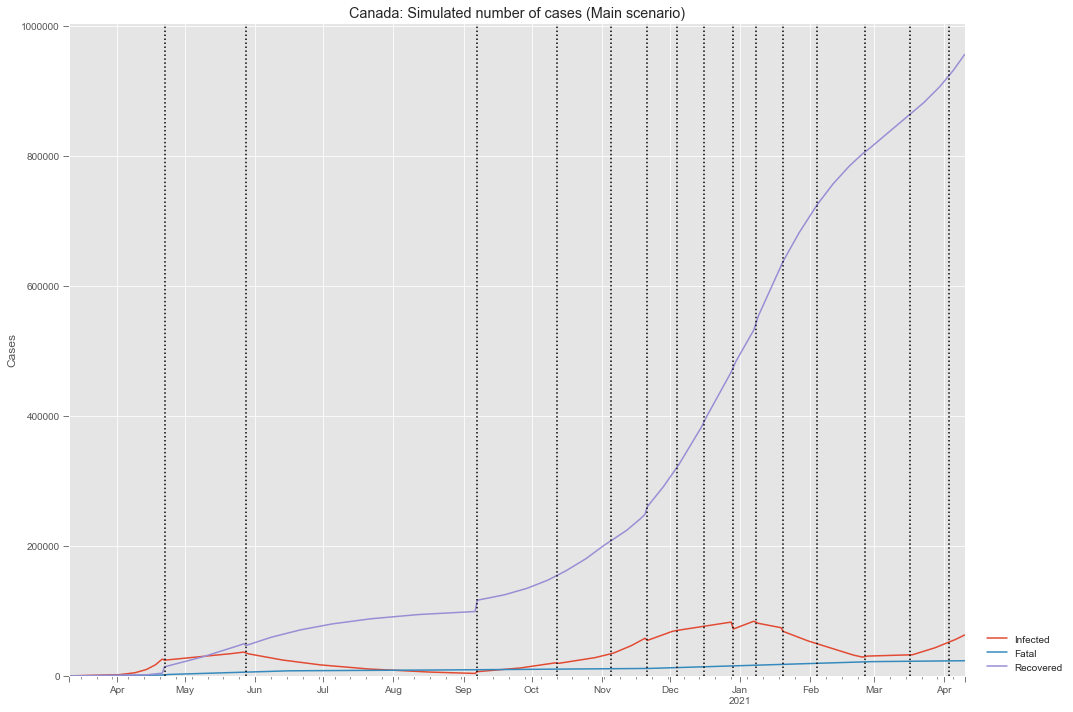

,Date,Confirmed,Fatal,Infected,Recovered
389,2021-04-04 00:00:00,1003556,23094,53020,927442
390,2021-04-05 00:00:00,1009630,23132,54557,931941
391,2021-04-06 00:00:00,1015881,23172,56138,936571
392,2021-04-07 00:00:00,1022312,23213,57764,941335
393,2021-04-08 00:00:00,1028927,23256,59435,946236
394,2021-04-09 00:00:00,1035733,23299,61154,951280
395,2021-04-10 00:00:00,1042734,23344,62921,956469


In [83]:
can_scenario.clear()
can_scenario.add(days=7)
can_scenario.simulate().tail(7).style.background_gradient(axis=0)

#### A month scenario

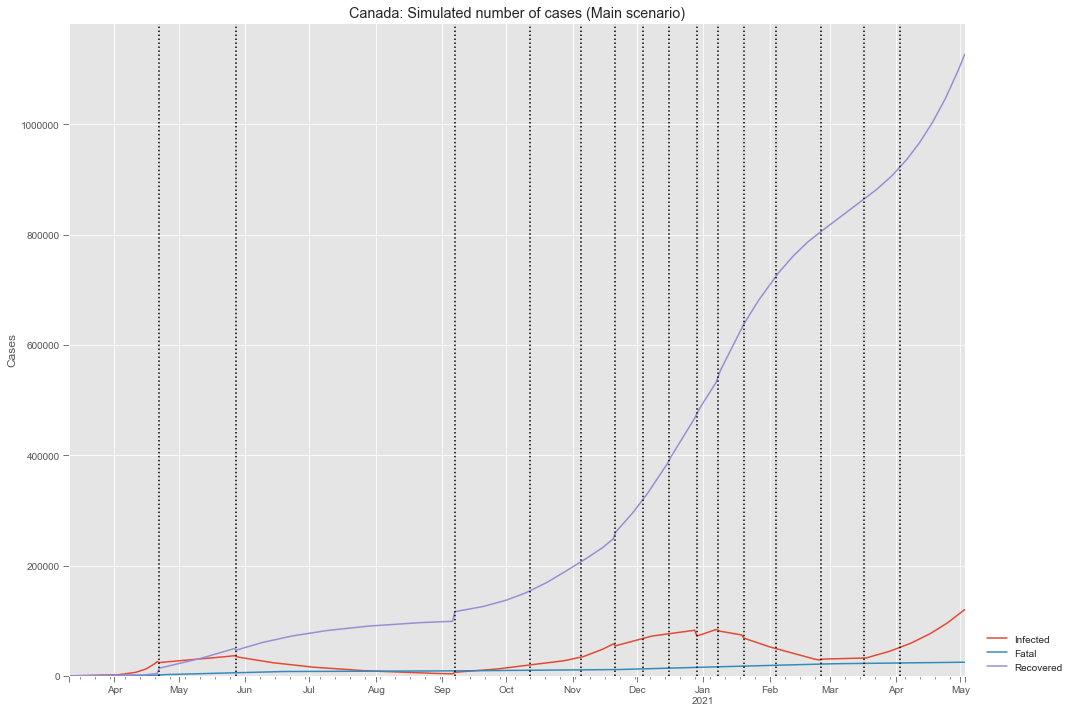

,Date,Confirmed,Fatal,Infected,Recovered
412,2021-04-27 00:00:00,1197451,24334,101707,1071410
413,2021-04-28 00:00:00,1209038,24408,104592,1080038
414,2021-04-29 00:00:00,1220950,24485,107554,1088911
415,2021-04-30 00:00:00,1233195,24563,110597,1098035
416,2021-05-01 00:00:00,1245782,24644,113721,1107417
417,2021-05-02 00:00:00,1258719,24727,116928,1117064
418,2021-05-03 00:00:00,1272017,24813,120221,1126983


In [84]:
can_scenario.clear()
can_scenario.add(days=30)
can_scenario.simulate().tail(7).style.background_gradient(axis=0)

#### In long term

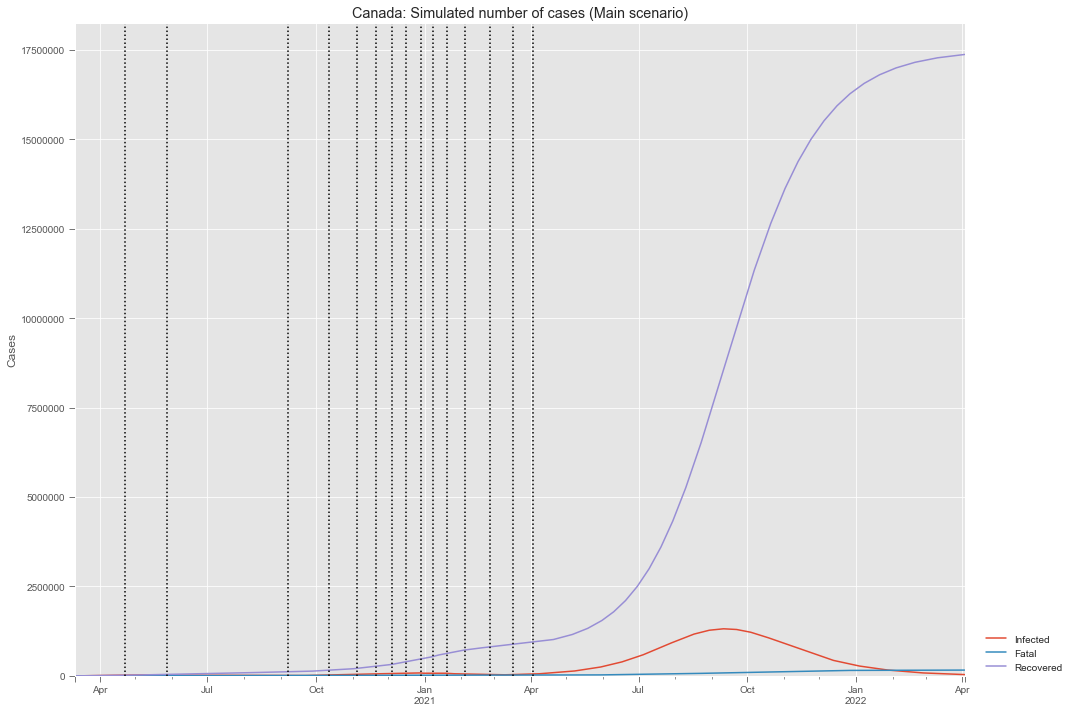

,Date,Confirmed,Fatal,Infected,Recovered
747,2022-03-28 00:00:00,17559289,162490,42415,17354384
748,2022-03-29 00:00:00,17561845,162519,41442,17357884
749,2022-03-30 00:00:00,17564341,162548,40490,17361303
750,2022-03-31 00:00:00,17566781,162576,39559,17364646
751,2022-04-01 00:00:00,17569165,162603,38650,17367912
752,2022-04-02 00:00:00,17571496,162630,37761,17371105
753,2022-04-03 00:00:00,17573773,162656,36891,17374226


In [85]:
can_scenario.clear()
can_scenario.add(days=365)
can_scenario.simulate().tail(7).style.background_gradient(axis=0)

In this graph we can see that if lockdown and school closures are implemented then infected and fatal cases will significantly drop after 1 year. 
We can also see that we will see a rise in number of infected person soon after cases drops to zero and people again decide to go out.

### Conclusion

 - With lockdown we were able to reduce the potential encounter by 13%-15%.
 - With lockdown &rho; (effective contact rate) we saw a 40% decrease from 0.2 to 0.12.
 - With lockdown g<sub>s</sub> (number of days susceptible person goes out) also reduced by ~71%.
 - With lockdown number of infected person also reduced by 58%. In real world it is in a range of (20%-30%).

### Model Deployement (AWS)

 - The above explained SIR and SIR-F model were also deployed on AWS cloud to easily simulate the scenarios for any country.
 - Front End was made using HTML & CSS.
 - Back End was made using Flask.
 - Model was made using Python. 
 - Github Link <a href="https://github.com/isohels/SIRModelDeployement">click here</a>

### References

 - Github Repo COVID-19 Model Simulation: https://github.com/isohels/SIRModel
 - Github Repo for AWS Model: https://github.com/isohels/SIRModelDeployement
 - Github Repo for CovsirPhy Model: https://github.com/lisphilar/covid19-sir
 - COVID19_line_list_data.csv: https://github.com/beoutbreakprepared/nCoV2019/blob/master/latest_data/latestdata.tar.gz
 - Mortality Rate: https://coronavirus.jhu.edu/data/mortality
 - SEWIR-F Model: https://github.com/lisphilar/covid19-sir
 - SEIR Model: http://indico.ictp.it/event/7960/session/3/contribution/19/material/slides/
 - Google Mobility Report: https://www.gstatic.com/covid19/mobility/2021-03-28_CA_Mobility_Report_en.pdf
 - Intervention Scan Data: https://www.cihi.ca/en/covid-19-intervention-scan